### Quantify spillovers from fire treatments

Let's calculate the effect of spillovers on our treatments. Here the treatment is the burn scar and not the low-intensity treatments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prescribed.estimate.rdrobust.rdplot import rdplot
from prescribed.estimate.rdrobust.rdrobust import rdrobust
from prescribed.plot import template_plots
from prescribed.utils import calculate_fire_pop_dens

from prescribed.estimate.create_distances import create_distances

In [3]:
# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

In [4]:
pop_zip = list(Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob("*.tif"))
pop_dict = {
    int(p.stem.split("_")[-3]): p
    for p in Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob("*.tif")
}

In [5]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[
    (mtbs.Event_ID.str.contains("CA"))
    & (mtbs.Incid_Type.isin(["Wildfire", "Prescribed Fire"]))
].to_crs("3310")
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

# Load California boundaries
ca = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("4326")

template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

In [6]:
pop_dens = calculate_fire_pop_dens(
    geoms=mtbs_ca,
    pop_raster_path="/mnt/sherlock/oak/prescribed_data/raw/population",
    mask=ca,
    template=template,
)

Calculating population density...: 100%|██████████| 1886/1886 [00:43<00:00, 43.75it/s]


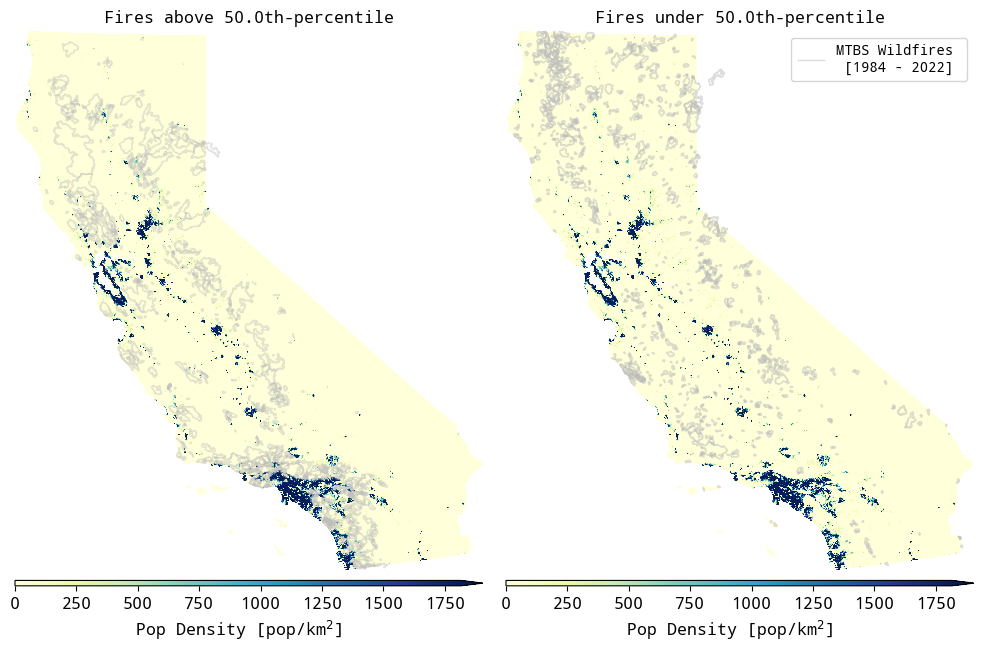

In [7]:
############################# PREPARE DATA FOR PLOT ############################
ds = rioxarray.open_rasterio(pop_dict[2020]).squeeze()

with xr.set_options(keep_attrs=True):
    clip_box = ds.rio.clip_box(*ca.total_bounds)
    cal_pop = clip_box.rio.clip(
        ca.geometry.values, ca.crs, drop=True, invert=False
    ).rio.reproject_match(template)

    cal_pop = xr.where(cal_pop == ds.attrs["_FillValue"], np.nan, cal_pop)
################################################################################


fig, ax = plt.subplots(1, 2, figsize=(10, 12))

thresh_def = 0.50

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

cal_pop.plot(
    robust=True,
    ax=ax[0],
    cbar_ax=cax,
    cmap="YlGnBu",
    cbar_kwargs={"label": r"Pop Density [pop/km$^2$]", "orientation": "horizontal"},
)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop >= tresh]

subset_events.geometry.boundary.plot(ax=ax[0], color="#bdbdbd", linewidth=1, alpha=0.4)

template_plots(ax[0], no_axis=True, ylab="", xlab="")

ax[0].set_title(f"Fires above {thresh_def * 100}th-percentile", fontsize=12)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Low density
cal_pop.plot(
    robust=True,
    ax=ax[1],
    cbar_ax=cax,
    cmap="YlGnBu",
    cbar_kwargs={"label": r"Pop Density [pop/km$^2$]", "orientation": "horizontal"},
)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop <= tresh]

subset_events.geometry.boundary.plot(
    ax=ax[1],
    color="#bdbdbd",
    linewidth=1,
    alpha=0.5,
    label="MTBS Wildfires \n [1984 - 2022]",
)
ax[1].legend(loc="upper right", fontsize=10)

template_plots(ax[1], no_axis=True, ylab="", xlab="")

ax[1].set_title(f"Fires under {thresh_def * 100}th-percentile", fontsize=12)

# Save plot
plt.tight_layout()
plt.savefig("../figs/pop_density_fires.png", dpi=300)

### Try the regression discontinuity and calculate some distances

In [45]:
from itertools import product

from joblib import Parallel, delayed
from prescribed.utils import tqdm_joblib
from tqdm import tqdm


def estimation_rdd(
    year: int,
    lag: int,
    data: pd.DataFrame,
    outcome_var: int,
    id_var="grid_id",
    plot_rdd=False,
) -> pd.DataFrame:
    """Regression discontinuity estimation for a given year and lag.

    Estimate a regression discontinuity using a panel dataset. The RDD is spatial,
    this function expects that data has a "distance" column that represents the
    discontinuity (centered in zero) and an id_var to merge the data.

    The regression will estimate the effects in time, so will use distance in time t
    to estimate the effect in time t+1  (assuming lag=1), and t+2 (lag=2), etc.

    Parameters
    ----------
    data : pd.DataFrame
        Panel data with distance, outcome_var and id_var columns.
    year : int
        Year of the treatment.
    lag : int
        Lag to estimate the effect of the treatment.
    outcome_var : str
        Outcome variable to estimate the RDD.
    id_var : str, optional
        Identifier variable to merge the data, by default "grid_id".
    plot_rdd : bool, optional
        Plot the RDD estimation, by default False.

    Returns
    -------
    pd.DataFrame
        RDD estimation results as a dataframe. The dataframe will have the following columns:
        - coef: Estimated coefficient
        - ci_low: Confidence interval
        - ci_high: Confidence interval
        - year: Year of the treatment
        - lag: Lag of the effect
        - bw: Bandwidth estimation
    """
    year_treat = year
    year_outcome = year + lag

    # Separate data to get consistent treatment and outcome years
    running_treat = data[data.year == year_treat][[id_var, "distance"]]
    outcome = data[data.year == year_outcome][[id_var, outcome_var]]

    # Fill in missing values for dnbr. Assume that if no measure, we have zero.
    outcome.loc[outcome[outcome_var] == 0, outcome_var] = np.nan
    outcome[outcome_var] = outcome[outcome_var].fillna(0)

    # Merge data for plotting
    data_reg = running_treat.merge(outcome, on=id_var, how="outer")

    # Running RDD esimation using Calonico, et.al., (2014) estimation
    try:
        est = rdrobust(
            y=data_reg[outcome_var].values, x=data_reg.distance.values, c=0, all=True
        )
        est_res = pd.concat([est.coef, est.ci], axis=1)
        est_res["year"] = year_treat
        est_res["lag"] = lag
        est_res["bw"] = est.bws["left"].values[0]

        if plot_rdd:
            # Subset to the bandwidth estimation only (the rest is not valid in the RDD context)
            h_l, h_r = est.bws.loc["h", :].values
            subset = (-h_l <= data_reg.distance.values) & (
                data_reg.distance.values <= h_r
            )

            # RD-plot with 95% confidence intervals
            _, rd_bins, rd_poly = rdplot(
                y=data_reg[outcome_var].values,
                x=data_reg.distance.values,
                subset=subset,
                kernel="triangular",
                h=[h_l, h_r],
                ci=95,
                title="",
                y_label=r"$dNBR$ at time $t+1$",
                x_label=r"Distance to wildfire boundary in time $t$",
                plot=False,
            )

            # Add year of treatment to the plot
            rd_poly["year"] = year_treat
            rd_bins["year"] = year_treat

        # Rename the columns to get sensible names
        est_res = est_res.rename(
            columns={"Coeff": "coef", "CI Lower": "ci_low", "CI Upper": "ci_high"}
        )

    except Exception as e:
        pass
        print(f"Cannot estimate RDD for year/lag: {year}/{lag}: {e}")

        est_res, rd_poly, rd_bins = None, None, None

    # Define output
    if plot_rdd:
        return est_res, rd_bins, rd_poly
    else:
        return est_res


def parallel_run_estimation_rdd(lags: list, years: list, **kwargs) -> pd.DataFrame:
    """Run RDD estimation for multiple years and lags in parallel

    Parameters
    ----------
    lags : list
        List of lags to estimate the RDD effect.
    years : list
        List of years to estimate the RDD effect.
    kwargs : dict
        Additional arguments to pass to `estimation_rdd`.
    """

    # Run RDD estimation in parallel
    with tqdm_joblib(
        tqdm(desc="RDD calculation", total=len(lags) * len(years))
    ) as progress_bar:
        results = Parallel(n_jobs=18)(
            delayed(estimation_rdd)(year, lag, **kwargs)
            for year, lag in product(years, lags)
        )

    # Concatenate results
    if isinstance(results[0], tuple):
        est_res, rd_bins, rd_poly = zip(*results)
        est_res = pd.concat(est_res)
        rd_bins = pd.concat(rd_bins)
        rd_poly = pd.concat(rd_poly)

        return est_res, rd_bins, rd_poly
    else:
        est_res = pd.concat(results)

        return est_res


def rdds_along_distances(
    outcome_df: pd.DataFrame, distances: list, rdd_kws: dict, dict_dist_kws: dict,
    save_path: str = None
) -> pd.DataFrame:
    """Run multiple RDD estimations for different lags, years, and distances"""

    list_dfs = []
    for buf in distances:
        distance_df = create_distances(
            mtbs_shapefile=dict_dist_kws["mtbs_shapefile"],
            template=dict_dist_kws["template"],
            pop_threshold=dict_dist_kws["pop_threshold"],
            buffer_treatment=buf,
            buffer=buf * 2,
            pop_raster_path=dict_dist_kws["pop_raster_path"],
            mask=dict_dist_kws["mask"],
        )

        distance_df = distance_df.dropna(subset="grid_id")

        # Merge with dnbr data to get outcomes
        distance_df = distance_df.merge(
            outcome_df, on=[rdd_kws["id_var"], "year"], how="left"
        )

        # Run RDD estimation in parallel for all years/lags
        est_res = parallel_run_estimation_rdd(
            lags=rdd_kws["lags"],
            years=rdd_kws["years"],
            data=distance_df,
            outcome_var=rdd_kws["outcome_var"],
            id_var=rdd_kws["id_var"],
            plot_rdd=False,
        )

        print(est_res.shape)

        # Create a dummy var if Coeff is significant using the CIs
        est_res["insignificant"] = (est_res["ci_low"] <= 0) & (est_res["ci_high"] > 0)

        est_res["treat_buffer"] = buf
        list_dfs.append(est_res)

    if save_path:
        pd.concat(list_dfs).to_csv(save_path, index=True)

    return pd.concat(list_dfs)

In [18]:
# Merge with dnbr data to get outcomes
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee/dnbr_long.feather"
)

dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID", how="left"
).drop(columns=["lat", "lon", "event_id"])

dist_results = rdds_along_distances(
    outcome_df=dnbr,
    distances=[3_000, 5_000, 10_000, 15_000, 20_000],
    rdd_kws={
        "lags": range(1, 12),
        "years": range(2000, 2021),
        "outcome_var": "dnbr",
        "id_var": "grid_id",
        "plot_rdd": False,
    },
    dict_dist_kws={
        "mtbs_shapefile": mtbs_ca,
        "template": template,
        "pop_threshold": 0.75,
        "pop_raster_path": "/mnt/sherlock/oak/prescribed_data/raw/population",
        "mask": ca,
    },
)

RDD calculation:   0%|          | 0/231 [00:00<?, ?it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   0%|          | 1/231 [00:08<30:42,  8.01s/it]

Cannot estimate RDD for year/lag: 2000/1: Matrix is not positive definite


RDD calculation:   1%|          | 2/231 [00:09<15:20,  4.02s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/2: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   1%|▏         | 3/231 [00:10<10:25,  2.74s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/4: Matrix is not positive definite


RDD calculation:   2%|▏         | 4/231 [00:11<08:02,  2.13s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   2%|▏         | 5/231 [00:13<07:12,  1.91s/it]

Mass points detected in the running variable.


RDD calculation:   3%|▎         | 6/231 [00:14<06:50,  1.83s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/7: Matrix is not positive definite


RDD calculation:   3%|▎         | 8/231 [00:16<04:29,  1.21s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/8: Matrix is not positive definite


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: invalid value encountered in double_scalars


Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: divide by zero encountered in double_scalars
RDD calculation:   4%|▍         | 9/231 [00:18<05:43,  1.55s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/10: Matrix is not positive definite


RDD calculation:   4%|▍         | 10/231 [00:18<04:23,  1.19s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/11: Matrix is not positive definite


RDD calculation:   5%|▍         | 11/231 [00:19<04:19,  1.18s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   6%|▌         | 13/231 [00:23<04:57,  1.37s/it]

Cannot estimate RDD for year/lag: 2001/2: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   6%|▌         | 14/231 [00:25<06:05,  1.68s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   6%|▋         | 15/231 [00:27<05:37,  1.56s/it]

Cannot estimate RDD for year/lag: 2001/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   7%|▋         | 16/231 [00:28<05:17,  1.48s/it]

Cannot estimate RDD for year/lag: 2001/6: Matrix is not positive definite


RDD calculation:   8%|▊         | 18/231 [00:29<03:50,  1.08s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2001/7: Matrix is not positive definite


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:504: RuntimeWarning: invalid value encountered in double_scalars
RDD calculation:   8%|▊         | 19/231 [00:29<03:03,  1.15it/s]

Cannot estimate RDD for year/lag: 2001/10: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2001/8: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2001/9: Matrix is not positive definite


RDD calculation:   9%|▉         | 21/231 [00:31<02:40,  1.31it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 22/231 [00:34<04:54,  1.41s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 23/231 [00:36<05:03,  1.46s/it]

Cannot estimate RDD for year/lag: 2002/1: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  11%|█         | 25/231 [00:38<04:27,  1.30s/it]

Cannot estimate RDD for year/lag: 2002/3: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  12%|█▏        | 27/231 [00:42<04:59,  1.47s/it]

Mass points detected in the running variable.


RDD calculation:  12%|█▏        | 28/231 [00:42<03:51,  1.14s/it]

Cannot estimate RDD for year/lag: 2002/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 29/231 [00:43<03:58,  1.18s/it]

Cannot estimate RDD for year/lag: 2002/7: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 30/231 [00:46<05:12,  1.56s/it]

Cannot estimate RDD for year/lag: 2002/9: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  14%|█▍        | 33/231 [00:50<04:25,  1.34s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  15%|█▍        | 34/231 [00:50<03:31,  1.07s/it]

Mass points detected in the running variable.


RDD calculation:  15%|█▌        | 35/231 [00:51<03:40,  1.13s/it]

Cannot estimate RDD for year/lag: 2003/3: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2003/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 37/231 [00:53<03:42,  1.15s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  17%|█▋        | 39/231 [00:56<03:55,  1.22s/it]

Mass points detected in the running variable.


RDD calculation:  17%|█▋        | 40/231 [00:57<03:50,  1.21s/it]

Mass points detected in the running variable.


RDD calculation:  18%|█▊        | 41/231 [00:58<03:04,  1.03it/s]

Cannot estimate RDD for year/lag: 2003/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  18%|█▊        | 42/231 [00:59<03:16,  1.04s/it]

Cannot estimate RDD for year/lag: 2003/9: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  19%|█▊        | 43/231 [01:01<04:28,  1.43s/it]

Cannot estimate RDD for year/lag: 2003/11: Matrix is not positive definite
Mass points detected in the running variable.

RDD calculation:  19%|█▉        | 44/231 [01:02<03:53,  1.25s/it]


Cannot estimate RDD for year/lag: 2004/1: Matrix is not positive definite


RDD calculation:  20%|█▉        | 46/231 [01:03<02:59,  1.03it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/2: Matrix is not positive definite


RDD calculation:  20%|██        | 47/231 [01:04<03:10,  1.04s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/3: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2004/4: Matrix is not positive definite


RDD calculation:  21%|██        | 48/231 [01:05<02:37,  1.16it/s]

Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:504: RuntimeWarning: invalid value encountered in double_scalars
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:938: RuntimeWarning: divide by zero encountered in divide
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:938: RuntimeWarning: invalid value encountered in divide
RDD calculation:  21%|██        | 49/231 [01:07<03:50,  1.27s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 51/231 [01:09<03:00,  1.00s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  23%|██▎       | 52/231 [01:11<03:47,  1.27s/it]

Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 53/231 [01:12<03:42,  1.25s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 54/231 [01:14<04:39,  1.58s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/11: Matrix is not positive definite


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  24%|██▍       | 55/231 [01:15<03:37,  1.24s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  24%|██▍       | 56/231 [01:16<03:37,  1.24s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  25%|██▍       | 57/231 [01:17<03:32,  1.22s/it]

Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 59/231 [01:19<03:15,  1.14s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/4: Matrix is not positive definite


RDD calculation:  26%|██▌       | 60/231 [01:20<03:20,  1.17s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  27%|██▋       | 62/231 [01:23<03:18,  1.17s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/7: Matrix is not positive definite


RDD calculation:  27%|██▋       | 63/231 [01:24<03:21,  1.20s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/8: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  28%|██▊       | 65/231 [01:27<03:20,  1.21s/it]

Mass points detected in the running variable.


RDD calculation:  29%|██▊       | 66/231 [01:28<03:21,  1.22s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 67/231 [01:38<10:20,  3.79s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2006/1: Matrix is not positive definite


RDD calculation:  29%|██▉       | 68/231 [01:40<09:20,  3.44s/it]

Cannot estimate RDD for year/lag: 2006/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  30%|██▉       | 69/231 [01:41<06:49,  2.53s/it]

Cannot estimate RDD for year/lag: 2006/3: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  30%|███       | 70/231 [01:46<08:58,  3.34s/it]

Mass points detected in the running variable.


RDD calculation:  31%|███       | 71/231 [01:46<06:32,  2.46s/it]

Mass points detected in the running variable.


RDD calculation:  31%|███       | 72/231 [01:48<05:57,  2.25s/it]

Cannot estimate RDD for year/lag: 2006/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 74/231 [01:50<03:48,  1.46s/it]

Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 75/231 [01:52<04:16,  1.64s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2007/2: Matrix is not positive definite


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  33%|███▎      | 76/231 [01:53<04:02,  1.56s/it]

Cannot estimate RDD for year/lag: 2007/4: Matrix is not positive definite


RDD calculation:  33%|███▎      | 77/231 [01:54<03:06,  1.21s/it]

Mass points detected in the running variable.


RDD calculation:  35%|███▍      | 80/231 [01:56<02:32,  1.01s/it]

Cannot estimate RDD for year/lag: 2006/11: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2006/10: Matrix is not positive definite


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  36%|███▌      | 83/231 [01:57<01:38,  1.50it/s]

Mass points detected in the running variable.


RDD calculation:  36%|███▋      | 84/231 [01:59<01:56,  1.26it/s]

Cannot estimate RDD for year/lag: 2007/7: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: divide by zero encountered in double_scalars


Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 87/231 [02:03<02:21,  1.02it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2007/10: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 88/231 [02:05<02:52,  1.21s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  39%|███▊      | 89/231 [02:26<13:53,  5.87s/it]

Cannot estimate RDD for year/lag: 2009/1: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2008/2: Matrix is not positive definite


RDD calculation:  39%|███▉      | 90/231 [02:26<10:41,  4.55s/it]

Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 91/231 [02:28<08:50,  3.79s/it]

Cannot estimate RDD for year/lag: 2009/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  40%|███▉      | 92/231 [02:30<07:45,  3.35s/it]

Cannot estimate RDD for year/lag: 2009/3: Matrix is not positive definite


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  40%|████      | 93/231 [02:33<06:59,  3.04s/it]

Cannot estimate RDD for year/lag: 2008/5: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 97/231 [02:35<02:51,  1.28s/it]

Cannot estimate RDD for year/lag: 2008/7: Matrix is not positive definite


RDD calculation:  42%|████▏     | 98/231 [02:35<02:17,  1.04s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  43%|████▎     | 99/231 [02:37<02:43,  1.24s/it]

Cannot estimate RDD for year/lag: 2008/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  45%|████▍     | 103/231 [02:38<01:29,  1.42it/s]

Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 104/231 [02:40<01:54,  1.11it/s]

Cannot estimate RDD for year/lag: 2009/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  46%|████▌     | 106/231 [02:42<01:58,  1.06it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2009/10: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2008/9: Matrix is not positive definite


RDD calculation:  47%|████▋     | 108/231 [02:43<01:17,  1.60it/s]

Cannot estimate RDD for year/lag: 2010/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  47%|████▋     | 109/231 [02:43<01:24,  1.44it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  48%|████▊     | 110/231 [02:44<01:21,  1.48it/s]

Cannot estimate RDD for year/lag: 2010/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 111/231 [02:45<01:40,  1.20it/s]

Cannot estimate RDD for year/lag: 2010/3: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2010/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  49%|████▉     | 113/231 [02:48<01:54,  1.03it/s]

Cannot estimate RDD for year/lag: 2008/11: Matrix is not positive definite


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  49%|████▉     | 114/231 [02:49<01:52,  1.04it/s]

Mass points detected in the running variable.


RDD calculation:  50%|████▉     | 115/231 [02:49<01:36,  1.20it/s]

Cannot estimate RDD for year/lag: 2010/6: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  50%|█████     | 116/231 [02:51<02:16,  1.19s/it]

Mass points detected in the running variable.


RDD calculation:  51%|█████     | 118/231 [02:53<01:44,  1.08it/s]

Cannot estimate RDD for year/lag: 2010/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 119/231 [02:54<01:55,  1.04s/it]

Cannot estimate RDD for year/lag: 2010/9: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  52%|█████▏    | 120/231 [02:55<02:02,  1.10s/it]

Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 121/231 [02:55<01:35,  1.15it/s]

Cannot estimate RDD for year/lag: 2010/11: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 122/231 [02:57<01:51,  1.03s/it]

Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 123/231 [02:59<02:21,  1.31s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2011/2: Matrix is not positive definite


RDD calculation:  54%|█████▎    | 124/231 [02:59<01:53,  1.06s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  54%|█████▍    | 125/231 [03:01<02:01,  1.15s/it]

Mass points detected in the running variable.


RDD calculation:  55%|█████▍    | 126/231 [03:02<02:00,  1.14s/it]

Cannot estimate RDD for year/lag: 2011/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  55%|█████▍    | 127/231 [03:03<02:02,  1.17s/it]

Cannot estimate RDD for year/lag: 2011/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  55%|█████▌    | 128/231 [03:05<02:16,  1.33s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


RDD calculation:  56%|█████▌    | 129/231 [03:06<02:05,  1.23s/it]

Mass points detected in the running variable.


RDD calculation:  56%|█████▋    | 130/231 [03:07<02:01,  1.20s/it]

Cannot estimate RDD for year/lag: 2011/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  57%|█████▋    | 131/231 [03:08<02:04,  1.25s/it]

Cannot estimate RDD for year/lag: 2011/11: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  57%|█████▋    | 132/231 [03:09<01:44,  1.06s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 134/231 [03:18<03:57,  2.45s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  58%|█████▊    | 135/231 [03:19<03:33,  2.22s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2012/5: Matrix is not positive definite


RDD calculation:  60%|█████▉    | 138/231 [03:21<01:47,  1.16s/it]

Cannot estimate RDD for year/lag: 2012/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  60%|██████    | 139/231 [03:22<01:41,  1.10s/it]

Cannot estimate RDD for year/lag: 2012/6: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2012/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  61%|██████    | 141/231 [03:24<01:37,  1.08s/it]

Mass points detected in the running variable.


RDD calculation:  61%|██████▏   | 142/231 [03:26<01:43,  1.16s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


RDD calculation:  62%|██████▏   | 143/231 [03:26<01:21,  1.08it/s]

Mass points detected in the running variable.


RDD calculation:  63%|██████▎   | 145/231 [03:28<01:24,  1.02it/s]

Cannot estimate RDD for year/lag: 2013/3: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  63%|██████▎   | 146/231 [03:30<01:37,  1.14s/it]

Mass points detected in the running variable.


RDD calculation:  64%|██████▎   | 147/231 [03:31<01:32,  1.10s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Cannot estimate RDD for year/lag: 2013/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  65%|██████▍   | 149/231 [03:32<01:13,  1.12it/s]

Cannot estimate RDD for year/lag: 2013/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  65%|██████▍   | 150/231 [03:33<01:17,  1.05it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2013/7: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2013/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  66%|██████▌   | 152/231 [03:34<01:05,  1.20it/s]

Cannot estimate RDD for year/lag: 2013/8: Matrix is not positive definite


RDD calculation:  66%|██████▌   | 153/231 [03:35<01:06,  1.18it/s]

Cannot estimate RDD for year/lag: 2013/10: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2013/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  67%|██████▋   | 154/231 [03:36<01:02,  1.24it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  67%|██████▋   | 155/231 [03:40<02:14,  1.78s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2014/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 157/231 [03:43<01:49,  1.48s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2014/3: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  68%|██████▊   | 158/231 [03:44<01:50,  1.52s/it]

Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: divide by zero encountered in double_scalars
RDD calculation:  69%|██████▉   | 159/231 [03:46<01:46,  1.48s/it]

Cannot estimate RDD for year/lag: 2014/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  70%|██████▉   | 161/231 [03:47<01:10,  1.01s/it]

Cannot estimate RDD for year/lag: 2014/6: Matrix is not positive definite


RDD calculation:  70%|███████   | 162/231 [03:47<00:52,  1.32it/s]

Cannot estimate RDD for year/lag: 2014/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  71%|███████   | 163/231 [03:48<00:49,  1.38it/s]

Cannot estimate RDD for year/lag: 2014/7: Matrix is not positive definite


RDD calculation:  71%|███████   | 164/231 [03:49<00:58,  1.15it/s]

Cannot estimate RDD for year/lag: 2014/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  71%|███████▏  | 165/231 [03:50<01:03,  1.04it/s]

Cannot estimate RDD for year/lag: 2014/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:504: RuntimeWarning: invalid value encountered in double_scalars


Cannot estimate RDD for year/lag: 2015/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  72%|███████▏  | 167/231 [03:57<02:19,  2.18s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2015/1: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2015/3: Matrix is not positive definite


RDD calculation:  74%|███████▎  | 170/231 [03:59<01:11,  1.18s/it]

Cannot estimate RDD for year/lag: 2015/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  74%|███████▍  | 171/231 [04:00<01:12,  1.21s/it]

Cannot estimate RDD for year/lag: 2015/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2015/5: Matrix is not positive definite


RDD calculation:  75%|███████▍  | 173/231 [04:01<00:54,  1.06it/s]

Cannot estimate RDD for year/lag: 2015/9: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  75%|███████▌  | 174/231 [04:03<00:59,  1.04s/it]

Cannot estimate RDD for year/lag: 2015/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 176/231 [04:03<00:38,  1.42it/s]

Cannot estimate RDD for year/lag: 2015/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  77%|███████▋  | 177/231 [04:07<01:33,  1.72s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2016/1: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  77%|███████▋  | 178/231 [04:09<01:29,  1.69s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  78%|███████▊  | 180/231 [04:11<01:09,  1.36s/it]

Cannot estimate RDD for year/lag: 2016/6: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  79%|███████▉  | 182/231 [04:12<00:49,  1.01s/it]

Cannot estimate RDD for year/lag: 2016/7: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2016/5: Matrix is not positive definite


RDD calculation:  80%|███████▉  | 184/231 [04:13<00:33,  1.40it/s]

Cannot estimate RDD for year/lag: 2016/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  80%|████████  | 185/231 [04:14<00:38,  1.19it/s]

Cannot estimate RDD for year/lag: 2016/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████  | 186/231 [04:16<00:47,  1.05s/it]

Cannot estimate RDD for year/lag: 2016/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████  | 187/231 [04:17<00:47,  1.07s/it]

Cannot estimate RDD for year/lag: 2016/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  81%|████████▏ | 188/231 [04:23<01:40,  2.34s/it]

Cannot estimate RDD for year/lag: 2017/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 189/231 [04:24<01:22,  1.97s/it]

Cannot estimate RDD for year/lag: 2017/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 190/231 [04:25<01:12,  1.77s/it]

Cannot estimate RDD for year/lag: 2017/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 191/231 [04:26<01:04,  1.62s/it]

Cannot estimate RDD for year/lag: 2017/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 192/231 [04:28<00:59,  1.52s/it]

Cannot estimate RDD for year/lag: 2017/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▎ | 193/231 [04:28<00:49,  1.31s/it]

Cannot estimate RDD for year/lag: 2017/1: Matrix is not positive definite


RDD calculation:  84%|████████▍ | 194/231 [04:30<00:47,  1.27s/it]

Cannot estimate RDD for year/lag: 2017/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▍ | 195/231 [04:30<00:40,  1.12s/it]

Cannot estimate RDD for year/lag: 2017/11: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  85%|████████▍ | 196/231 [04:31<00:35,  1.03s/it]

Mass points detected in the running variable.


RDD calculation:  85%|████████▌ | 197/231 [04:33<00:46,  1.38s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


RDD calculation:  86%|████████▌ | 198/231 [04:35<00:43,  1.33s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


RDD calculation:  86%|████████▌ | 199/231 [04:36<00:42,  1.32s/it]

Cannot estimate RDD for year/lag: 2018/4: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2018/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 201/231 [04:38<00:30,  1.01s/it]

Cannot estimate RDD for year/lag: 2018/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2018/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 203/231 [04:40<00:30,  1.08s/it]

Cannot estimate RDD for year/lag: 2018/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▊ | 205/231 [04:40<00:17,  1.50it/s]

Cannot estimate RDD for year/lag: 2018/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|████████▉ | 207/231 [04:42<00:16,  1.44it/s]

Cannot estimate RDD for year/lag: 2018/3: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2018/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 208/231 [04:43<00:23,  1.00s/it]

Cannot estimate RDD for year/lag: 2018/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 209/231 [04:45<00:23,  1.06s/it]

Cannot estimate RDD for year/lag: 2018/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  91%|█████████ | 210/231 [04:47<00:30,  1.46s/it]

Mass points detected in the running variable.


RDD calculation:  91%|█████████▏| 211/231 [04:48<00:24,  1.24s/it]

Cannot estimate RDD for year/lag: 2019/3: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/2: Matrix is not positive definite


RDD calculation:  92%|█████████▏| 213/231 [04:50<00:20,  1.16s/it]

Cannot estimate RDD for year/lag: 2019/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 214/231 [04:50<00:15,  1.08it/s]

Cannot estimate RDD for year/lag: 2019/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 215/231 [04:52<00:18,  1.15s/it]

Cannot estimate RDD for year/lag: 2019/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▎| 216/231 [04:53<00:17,  1.17s/it]

Cannot estimate RDD for year/lag: 2019/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 217/231 [04:54<00:16,  1.20s/it]

Cannot estimate RDD for year/lag: 2019/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 218/231 [04:55<00:13,  1.05s/it]

Cannot estimate RDD for year/lag: 2019/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▍| 219/231 [04:57<00:14,  1.24s/it]

Cannot estimate RDD for year/lag: 2019/10: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▌| 220/231 [04:58<00:14,  1.31s/it]

Mass points detected in the running variable.


RDD calculation:  96%|█████████▌| 221/231 [05:00<00:14,  1.41s/it]

Cannot estimate RDD for year/lag: 2020/2: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 222/231 [05:02<00:13,  1.47s/it]

Cannot estimate RDD for year/lag: 2020/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 223/231 [05:03<00:11,  1.40s/it]

Cannot estimate RDD for year/lag: 2020/4: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2020/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 225/231 [05:05<00:06,  1.15s/it]

Cannot estimate RDD for year/lag: 2020/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  98%|█████████▊| 226/231 [05:06<00:05,  1.17s/it]

Cannot estimate RDD for year/lag: 2020/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  98%|█████████▊| 227/231 [05:07<00:04,  1.19s/it]

Cannot estimate RDD for year/lag: 2020/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▊| 228/231 [05:09<00:04,  1.34s/it]

Cannot estimate RDD for year/lag: 2020/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▉| 229/231 [05:09<00:02,  1.11s/it]

Cannot estimate RDD for year/lag: 2020/10: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|█████████▉| 230/231 [05:11<00:01,  1.12s/it]

Cannot estimate RDD for year/lag: 2020/11: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation: 100%|██████████| 231/231 [05:20<00:00,  1.39s/it]


(264, 6)


RDD calculation:   0%|          | 0/231 [00:00<?, ?it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   0%|          | 1/231 [00:08<30:46,  8.03s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   1%|          | 2/231 [00:09<15:27,  4.05s/it]

Mass points detected in the running variable.


RDD calculation:   1%|▏         | 3/231 [00:10<11:12,  2.95s/it]

Mass points detected in the running variable.


RDD calculation:   2%|▏         | 4/231 [00:12<08:33,  2.26s/it]

Mass points detected in the running variable.


RDD calculation:   2%|▏         | 5/231 [00:14<08:20,  2.21s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   3%|▎         | 7/231 [00:16<06:17,  1.69s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/10: Matrix is not positive definite


RDD calculation:   4%|▍         | 10/231 [00:18<03:32,  1.04it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   5%|▍         | 11/231 [00:20<05:03,  1.38s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   5%|▌         | 12/231 [00:23<06:21,  1.74s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


RDD calculation:   6%|▌         | 13/231 [00:25<06:11,  1.71s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   6%|▌         | 14/231 [00:26<05:24,  1.50s/it]

Mass points detected in the running variable.


RDD calculation:   6%|▋         | 15/231 [00:27<05:11,  1.44s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2001/5: Matrix is not positive definite


RDD calculation:   7%|▋         | 16/231 [00:27<04:05,  1.14s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2001/6: Matrix is not positive definite


RDD calculation:   8%|▊         | 18/231 [00:30<03:59,  1.12s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2001/10: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2001/7: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2001/8: Matrix is not positive definite


RDD calculation:   9%|▊         | 20/231 [00:31<03:31,  1.00s/it]

Mass points detected in the running variable.


RDD calculation:   9%|▉         | 21/231 [00:34<04:35,  1.31s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 22/231 [00:35<04:53,  1.40s/it]

Cannot estimate RDD for year/lag: 2001/11: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 23/231 [00:39<07:00,  2.02s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2002/1: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  10%|█         | 24/231 [00:41<07:20,  2.13s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  11%|█         | 25/231 [00:45<08:49,  2.57s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2002/6: Matrix is not positive definite


RDD calculation:  12%|█▏        | 27/231 [00:46<05:42,  1.68s/it]

Cannot estimate RDD for year/lag: 2002/3: Matrix is not positive definite


RDD calculation:  12%|█▏        | 28/231 [00:47<04:39,  1.38s/it]

Cannot estimate RDD for year/lag: 2002/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 29/231 [00:47<04:12,  1.25s/it]

Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 30/231 [00:50<05:38,  1.69s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2002/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 32/231 [00:52<04:00,  1.21s/it]

Cannot estimate RDD for year/lag: 2002/10: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2003/1: Matrix is not positive definite


RDD calculation:  14%|█▍        | 33/231 [00:53<04:23,  1.33s/it]

Mass points detected in the running variable.


RDD calculation:  15%|█▍        | 34/231 [00:55<04:24,  1.34s/it]

Cannot estimate RDD for year/lag: 2003/2: Matrix is not positive definite


RDD calculation:  15%|█▌        | 35/231 [00:55<03:35,  1.10s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2003/3: Matrix is not positive definite


RDD calculation:  16%|█▌        | 36/231 [00:56<03:24,  1.05s/it]

Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 37/231 [00:57<03:39,  1.13s/it]

Cannot estimate RDD for year/lag: 2003/4: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  16%|█▋        | 38/231 [01:00<05:03,  1.57s/it]

Cannot estimate RDD for year/lag: 2003/6: Matrix is not positive definite


RDD calculation:  17%|█▋        | 39/231 [01:01<04:31,  1.41s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  17%|█▋        | 40/231 [01:03<04:48,  1.51s/it]

Cannot estimate RDD for year/lag: 2003/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  18%|█▊        | 42/231 [01:04<03:34,  1.13s/it]

Cannot estimate RDD for year/lag: 2003/9: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2003/10: Matrix is not positive definite


RDD calculation:  19%|█▊        | 43/231 [01:05<03:39,  1.17s/it]

Mass points detected in the running variable.


RDD calculation:  19%|█▉        | 44/231 [01:07<03:52,  1.24s/it]

Cannot estimate RDD for year/lag: 2003/11: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  19%|█▉        | 45/231 [01:09<05:03,  1.63s/it]

Cannot estimate RDD for year/lag: 2004/1: Matrix is not positive definite


RDD calculation:  20%|██        | 47/231 [01:10<03:10,  1.04s/it]

Cannot estimate RDD for year/lag: 2004/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  21%|██        | 48/231 [01:12<03:46,  1.24s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/4: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:514: RuntimeWarning: invalid value encountered in double_scalars
RDD calculation:  22%|██▏       | 50/231 [01:14<03:04,  1.02s/it]

Cannot estimate RDD for year/lag: 2004/7: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2004/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 51/231 [01:15<03:19,  1.11s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  23%|██▎       | 52/231 [01:17<04:20,  1.45s/it]

Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 53/231 [01:18<03:23,  1.15s/it]

Cannot estimate RDD for year/lag: 2004/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 54/231 [01:19<03:35,  1.22s/it]

Cannot estimate RDD for year/lag: 2004/10: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 55/231 [01:21<03:42,  1.26s/it]

Cannot estimate RDD for year/lag: 2004/11: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 56/231 [01:23<04:35,  1.58s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/1: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


RDD calculation:  25%|██▌       | 58/231 [01:27<05:00,  1.74s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/4: Matrix is not positive definite


RDD calculation:  26%|██▌       | 60/231 [01:28<03:35,  1.26s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/5: Matrix is not positive definite


RDD calculation:  26%|██▋       | 61/231 [01:30<03:54,  1.38s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/6: Matrix is not positive definite


RDD calculation:  27%|██▋       | 62/231 [01:31<03:36,  1.28s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/7: Matrix is not positive definite


RDD calculation:  27%|██▋       | 63/231 [01:32<03:36,  1.29s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/8: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:938: RuntimeWarning: divide by zero encountered in divide
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:938: RuntimeWarning: invalid value encountered in divide


Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/11: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2005/9: Matrix is not positive definite


RDD calculation:  28%|██▊       | 64/231 [01:37<06:10,  2.22s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 67/231 [01:54<11:22,  4.16s/it]

Cannot estimate RDD for year/lag: 2006/1: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 68/231 [01:59<11:38,  4.28s/it]

Cannot estimate RDD for year/lag: 2006/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  30%|██▉       | 69/231 [02:02<10:31,  3.90s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2006/6: Matrix is not positive definite


RDD calculation:  30%|███       | 70/231 [02:03<08:55,  3.33s/it]

Cannot estimate RDD for year/lag: 2006/7: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2007/1: Matrix is not positive definite

RDD calculation:  31%|███       | 71/231 [02:04<06:59,  2.62s/it]


Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 73/231 [02:08<06:04,  2.30s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2006/8: Matrix is not positive definite


RDD calculation:  32%|███▏      | 75/231 [02:08<03:35,  1.38s/it]

Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 77/231 [02:12<03:55,  1.53s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2006/10: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2006/11: Matrix is not positive definite


RDD calculation:  35%|███▌      | 81/231 [02:12<01:46,  1.41it/s]

Cannot estimate RDD for year/lag: 2007/7: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  36%|███▋      | 84/231 [02:17<02:14,  1.09it/s]

Cannot estimate RDD for year/lag: 2007/9: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2006/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  37%|███▋      | 86/231 [02:17<01:32,  1.58it/s]

Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 87/231 [02:19<02:29,  1.04s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 88/231 [02:23<03:52,  1.63s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  39%|███▊      | 89/231 [02:44<15:40,  6.63s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2009/1: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2009/2: Matrix is not positive definite

RDD calculation:  39%|███▉      | 90/231 [02:45<11:50,  5.04s/it]


Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 91/231 [02:47<10:04,  4.32s/it]

Cannot estimate RDD for year/lag: 2009/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  40%|███▉      | 92/231 [02:48<07:19,  3.16s/it]

Cannot estimate RDD for year/lag: 2009/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  40%|████      | 93/231 [02:52<08:06,  3.53s/it]

Cannot estimate RDD for year/lag: 2009/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  41%|████      | 94/231 [02:54<07:17,  3.19s/it]

Cannot estimate RDD for year/lag: 2009/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  41%|████      | 95/231 [02:57<06:44,  2.97s/it]

Cannot estimate RDD for year/lag: 2009/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 96/231 [02:58<05:41,  2.53s/it]

Cannot estimate RDD for year/lag: 2008/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 97/231 [03:01<05:32,  2.48s/it]

Cannot estimate RDD for year/lag: 2009/9: Matrix is not positive definite


RDD calculation:  42%|████▏     | 98/231 [03:03<05:21,  2.42s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2010/1: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2008/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  43%|████▎     | 100/231 [03:05<04:02,  1.85s/it]

Cannot estimate RDD for year/lag: 2010/2: Matrix is not positive definite


RDD calculation:  44%|████▎     | 101/231 [03:06<03:11,  1.47s/it]

Cannot estimate RDD for year/lag: 2009/11: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 104/231 [03:07<01:52,  1.13it/s]

Cannot estimate RDD for year/lag: 2010/3: Matrix is not positive definite


RDD calculation:  47%|████▋     | 108/231 [03:09<01:17,  1.58it/s]

Cannot estimate RDD for year/lag: 2008/5: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2010/4: Matrix is not positive definite


RDD calculation:  47%|████▋     | 109/231 [03:09<01:08,  1.78it/s]

Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 110/231 [03:11<01:37,  1.24it/s]

Cannot estimate RDD for year/lag: 2010/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 111/231 [03:12<01:58,  1.01it/s]

Cannot estimate RDD for year/lag: 2010/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 112/231 [03:14<02:19,  1.17s/it]

Cannot estimate RDD for year/lag: 2010/7: Matrix is not positive definite


RDD calculation:  49%|████▉     | 113/231 [03:14<01:50,  1.07it/s]

Cannot estimate RDD for year/lag: 2008/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  49%|████▉     | 114/231 [03:15<01:53,  1.03it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Cannot estimate RDD for year/lag: 2008/6: Matrix is not positive definite


RDD calculation:  50%|████▉     | 115/231 [03:16<01:34,  1.23it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  51%|█████     | 117/231 [03:19<01:53,  1.01it/s]

Cannot estimate RDD for year/lag: 2010/10: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2008/10: Matrix is not positive definite


RDD calculation:  52%|█████▏    | 120/231 [03:20<01:10,  1.57it/s]

Cannot estimate RDD for year/lag: 2010/11: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2011/1: Matrix is not positive definite


RDD calculation:  52%|█████▏    | 121/231 [03:21<01:16,  1.44it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 122/231 [03:22<01:33,  1.17it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2008/11: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2011/2: Matrix is not positive definite


RDD calculation:  54%|█████▎    | 124/231 [03:24<01:23,  1.28it/s]

Mass points detected in the running variable.


RDD calculation:  54%|█████▍    | 125/231 [03:25<01:40,  1.06it/s]

Mass points detected in the running variable.


RDD calculation:  55%|█████▍    | 126/231 [03:26<01:48,  1.03s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2011/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  55%|█████▌    | 128/231 [03:29<01:57,  1.14s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2011/7: Matrix is not positive definite


RDD calculation:  56%|█████▌    | 129/231 [03:30<01:59,  1.18s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  56%|█████▋    | 130/231 [03:32<02:10,  1.29s/it]

Cannot estimate RDD for year/lag: 2011/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  57%|█████▋    | 132/231 [03:33<01:33,  1.06it/s]

Cannot estimate RDD for year/lag: 2011/10: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  58%|█████▊    | 133/231 [03:46<07:34,  4.64s/it]

Cannot estimate RDD for year/lag: 2012/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  59%|█████▉    | 136/231 [03:49<03:50,  2.43s/it]

Cannot estimate RDD for year/lag: 2012/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  60%|█████▉    | 138/231 [03:51<02:43,  1.76s/it]

Cannot estimate RDD for year/lag: 2012/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  61%|██████    | 140/231 [03:53<01:58,  1.30s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  61%|██████▏   | 142/231 [03:55<01:47,  1.21s/it]

Mass points detected in the running variable.


RDD calculation:  62%|██████▏   | 144/231 [03:56<01:11,  1.22it/s]

Mass points detected in the running variable.


RDD calculation:  63%|██████▎   | 146/231 [03:57<00:53,  1.58it/s]

Cannot estimate RDD for year/lag: 2012/9: Matrix is not positive definite


RDD calculation:  64%|██████▎   | 147/231 [03:58<01:03,  1.33it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  65%|██████▍   | 149/231 [04:01<01:20,  1.01it/s]

Mass points detected in the running variable.


RDD calculation:  65%|██████▍   | 150/231 [04:02<01:25,  1.06s/it]

Cannot estimate RDD for year/lag: 2013/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  66%|██████▌   | 152/231 [04:02<00:52,  1.52it/s]

Cannot estimate RDD for year/lag: 2013/8: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2013/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  67%|██████▋   | 154/231 [04:04<01:06,  1.17it/s]

Cannot estimate RDD for year/lag: 2013/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2014/1: Matrix is not positive definite


RDD calculation:  68%|██████▊   | 156/231 [04:10<02:11,  1.75s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2014/2: Matrix is not positive definite


RDD calculation:  68%|██████▊   | 157/231 [04:12<02:00,  1.63s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2014/4: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2014/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  69%|██████▉   | 159/231 [04:14<01:46,  1.48s/it]

Cannot estimate RDD for year/lag: 2014/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2014/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  69%|██████▉   | 160/231 [04:16<01:41,  1.43s/it]

Cannot estimate RDD for year/lag: 2014/6: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2014/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  71%|███████▏  | 165/231 [04:19<00:56,  1.17it/s]

Cannot estimate RDD for year/lag: 2014/11: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2014/7: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2015/1: Matrix is not positive definite


RDD calculation:  72%|███████▏  | 166/231 [04:26<02:38,  2.44s/it]

Cannot estimate RDD for year/lag: 2015/7: zero-size array to reduction operation minimum which has no identity


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:514: RuntimeWarning: invalid value encountered in double_scalars
RDD calculation:  72%|███████▏  | 167/231 [04:27<02:13,  2.09s/it]

Cannot estimate RDD for year/lag: 2015/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2015/4: Matrix is not positive definite


RDD calculation:  74%|███████▎  | 170/231 [04:28<01:04,  1.05s/it]

Cannot estimate RDD for year/lag: 2015/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2015/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  74%|███████▍  | 172/231 [04:30<01:05,  1.10s/it]

Cannot estimate RDD for year/lag: 2015/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▌  | 174/231 [04:32<00:47,  1.20it/s]

Cannot estimate RDD for year/lag: 2015/5: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2015/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 176/231 [04:33<00:40,  1.37it/s]

Cannot estimate RDD for year/lag: 2015/6: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  77%|███████▋  | 177/231 [04:39<02:01,  2.26s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2016/1: Matrix is not positive definite


RDD calculation:  77%|███████▋  | 178/231 [04:40<01:44,  1.98s/it]

Cannot estimate RDD for year/lag: 2016/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  77%|███████▋  | 179/231 [04:40<01:18,  1.51s/it]

Cannot estimate RDD for year/lag: 2016/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2016/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 181/231 [04:41<00:50,  1.01s/it]

Cannot estimate RDD for year/lag: 2016/3: Matrix is not positive definite


RDD calculation:  79%|███████▉  | 182/231 [04:42<00:42,  1.14it/s]

Cannot estimate RDD for year/lag: 2016/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  79%|███████▉  | 183/231 [04:43<00:39,  1.21it/s]

Cannot estimate RDD for year/lag: 2016/4: Matrix is not positive definite


RDD calculation:  80%|███████▉  | 184/231 [04:43<00:34,  1.35it/s]

Cannot estimate RDD for year/lag: 2016/5: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2016/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  80%|████████  | 185/231 [04:44<00:34,  1.35it/s]

Cannot estimate RDD for year/lag: 2016/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████  | 187/231 [04:46<00:43,  1.01it/s]

Cannot estimate RDD for year/lag: 2016/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  81%|████████▏ | 188/231 [04:53<01:49,  2.55s/it]

Cannot estimate RDD for year/lag: 2017/5: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2017/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 190/231 [04:54<01:09,  1.69s/it]

Cannot estimate RDD for year/lag: 2017/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 191/231 [04:56<01:02,  1.57s/it]

Cannot estimate RDD for year/lag: 2017/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2017/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▎ | 193/231 [04:58<00:52,  1.38s/it]

Cannot estimate RDD for year/lag: 2017/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▍ | 194/231 [05:00<00:58,  1.59s/it]

Cannot estimate RDD for year/lag: 2017/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  84%|████████▍ | 195/231 [05:04<01:24,  2.34s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2017/1: Matrix is not positive definite


RDD calculation:  85%|████████▍ | 196/231 [05:06<01:12,  2.07s/it]

Cannot estimate RDD for year/lag: 2018/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▌ | 197/231 [05:06<00:55,  1.62s/it]

Cannot estimate RDD for year/lag: 2018/5: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2017/3: Matrix is not positive definite


RDD calculation:  87%|████████▋ | 200/231 [05:08<00:26,  1.16it/s]

Cannot estimate RDD for year/lag: 2017/4: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2018/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 201/231 [05:09<00:30,  1.01s/it]

Cannot estimate RDD for year/lag: 2018/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 203/231 [05:11<00:29,  1.04s/it]

Cannot estimate RDD for year/lag: 2018/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 204/231 [05:12<00:24,  1.09it/s]

Cannot estimate RDD for year/lag: 2018/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▊ | 205/231 [05:13<00:26,  1.02s/it]

Cannot estimate RDD for year/lag: 2018/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|████████▉ | 207/231 [05:15<00:19,  1.23it/s]

Cannot estimate RDD for year/lag: 2018/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2018/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 208/231 [05:17<00:25,  1.12s/it]

Mass points detected in the running variable.


RDD calculation:  90%|█████████ | 209/231 [05:17<00:20,  1.10it/s]

Mass points detected in the running variable.


RDD calculation:  91%|█████████ | 210/231 [05:19<00:27,  1.29s/it]

Cannot estimate RDD for year/lag: 2019/3: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/1: Matrix is not positive definite


RDD calculation:  92%|█████████▏| 212/231 [05:20<00:18,  1.04it/s]

Cannot estimate RDD for year/lag: 2019/4: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/2: Matrix is not positive definite


RDD calculation:  93%|█████████▎| 214/231 [05:22<00:14,  1.14it/s]

Cannot estimate RDD for year/lag: 2019/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 215/231 [05:23<00:14,  1.09it/s]

Cannot estimate RDD for year/lag: 2019/6: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 217/231 [05:25<00:12,  1.13it/s]

Cannot estimate RDD for year/lag: 2019/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 218/231 [05:26<00:14,  1.13s/it]

Cannot estimate RDD for year/lag: 2019/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▍| 219/231 [05:28<00:13,  1.15s/it]

Cannot estimate RDD for year/lag: 2019/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▌| 220/231 [05:29<00:12,  1.16s/it]

Cannot estimate RDD for year/lag: 2019/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  96%|█████████▌| 221/231 [05:31<00:13,  1.40s/it]

Cannot estimate RDD for year/lag: 2020/2: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 222/231 [05:32<00:11,  1.29s/it]

Cannot estimate RDD for year/lag: 2020/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 223/231 [05:33<00:10,  1.34s/it]

Cannot estimate RDD for year/lag: 2020/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 224/231 [05:35<00:10,  1.44s/it]

Cannot estimate RDD for year/lag: 2020/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 225/231 [05:36<00:08,  1.37s/it]

Cannot estimate RDD for year/lag: 2020/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  98%|█████████▊| 226/231 [05:37<00:05,  1.19s/it]

Cannot estimate RDD for year/lag: 2020/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  98%|█████████▊| 227/231 [05:39<00:05,  1.35s/it]

Cannot estimate RDD for year/lag: 2020/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▊| 228/231 [05:39<00:03,  1.16s/it]

Cannot estimate RDD for year/lag: 2020/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▉| 229/231 [05:40<00:02,  1.13s/it]

Cannot estimate RDD for year/lag: 2020/10: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|█████████▉| 230/231 [05:41<00:01,  1.14s/it]

Cannot estimate RDD for year/lag: 2020/11: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|██████████| 231/231 [06:00<00:00,  1.56s/it]


(216, 6)


RDD calculation:   0%|          | 0/231 [00:00<?, ?it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   0%|          | 1/231 [00:17<1:08:36, 17.90s/it]

Mass points detected in the running variable.


RDD calculation:   1%|          | 2/231 [00:20<32:59,  8.64s/it]  

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   2%|▏         | 5/231 [00:24<11:51,  3.15s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   3%|▎         | 6/231 [00:27<12:34,  3.35s/it]

Mass points detected in the running variable.

RDD calculation:   3%|▎         | 7/231 [00:29<10:14,  2.74s/it]


Mass points detected in the running variable.


RDD calculation:   3%|▎         | 8/231 [00:33<11:39,  3.14s/it]

Mass points detected in the running variable.


RDD calculation:   4%|▍         | 9/231 [00:33<08:42,  2.36s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   5%|▍         | 11/231 [00:39<08:14,  2.25s/it]

Mass points detected in the running variable.


RDD calculation:   6%|▌         | 13/231 [00:42<07:08,  1.97s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   6%|▌         | 14/231 [00:46<09:48,  2.71s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   7%|▋         | 16/231 [00:52<08:51,  2.47s/it]

Mass points detected in the running variable.


RDD calculation:   7%|▋         | 17/231 [00:54<08:50,  2.48s/it]

Mass points detected in the running variable.


RDD calculation:   8%|▊         | 18/231 [00:57<08:51,  2.49s/it]

Mass points detected in the running variable.


RDD calculation:   8%|▊         | 19/231 [01:00<09:26,  2.67s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   9%|▉         | 21/231 [01:02<06:25,  1.84s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: divide by zero encountered in double_scalars


Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 22/231 [01:14<17:23,  4.99s/it]

Mass points detected in the running variable.


RDD calculation:  10%|▉         | 23/231 [01:16<14:12,  4.10s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  11%|█▏        | 26/231 [01:30<13:12,  3.87s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  12%|█▏        | 28/231 [01:35<10:02,  2.97s/it]

Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 29/231 [01:37<08:48,  2.62s/it]

Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 30/231 [01:40<09:06,  2.72s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 32/231 [01:44<08:08,  2.45s/it]

Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 33/231 [01:47<08:40,  2.63s/it]

Mass points detected in the running variable.


RDD calculation:  15%|█▌        | 35/231 [01:49<06:14,  1.91s/it]

Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 37/231 [01:52<05:27,  1.69s/it]

Mass points detected in the running variable.


RDD calculation:  17%|█▋        | 40/231 [01:54<03:47,  1.19s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  18%|█▊        | 41/231 [01:59<05:38,  1.78s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  18%|█▊        | 42/231 [02:02<06:27,  2.05s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  19%|█▊        | 43/231 [02:08<09:51,  3.14s/it]

Mass points detected in the running variable.


RDD calculation:  19%|█▉        | 44/231 [02:10<09:03,  2.91s/it]

Mass points detected in the running variable.


RDD calculation:  19%|█▉        | 45/231 [02:14<09:09,  2.95s/it]

Mass points detected in the running variable.


RDD calculation:  21%|██        | 48/231 [02:16<05:13,  1.71s/it]

Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 50/231 [02:18<04:26,  1.47s/it]

Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 52/231 [02:20<03:36,  1.21s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 53/231 [02:25<05:49,  1.96s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 55/231 [02:30<06:24,  2.18s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.

RDD calculation:  24%|██▍       | 56/231 [02:36<09:03,  3.11s/it]

RDD calculation:  25%|██▍       | 57/231 [02:37<07:28,  2.58s/it]

Mass points detected in the running variable.


RDD calculation:  25%|██▌       | 58/231 [02:40<07:55,  2.75s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:514: RuntimeWarning: invalid value encountered in double_scalars
RDD calculation:  26%|██▌       | 59/231 [02:43<08:11,  2.86s/it]

Cannot estimate RDD for year/lag: 2005/10: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 62/231 [02:49<05:07,  1.82s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 63/231 [02:53<06:54,  2.47s/it]

Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 64/231 [02:56<07:23,  2.66s/it]

Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 65/231 [02:58<07:10,  2.59s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▊       | 66/231 [03:05<10:31,  3.83s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 67/231 [03:36<32:37, 11.94s/it]

Mass points detected in the running variable.


RDD calculation:  30%|███       | 70/231 [03:46<15:58,  5.95s/it]

Mass points detected in the running variable.


RDD calculation:  31%|███       | 71/231 [03:48<12:34,  4.72s/it]

Mass points detected in the running variable.


RDD calculation:  31%|███       | 72/231 [03:50<10:47,  4.07s/it]

Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 73/231 [03:53<09:26,  3.59s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 74/231 [04:04<15:23,  5.89s/it]

Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 77/231 [04:19<11:43,  4.57s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  35%|███▌      | 81/231 [04:29<07:07,  2.85s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  36%|███▌      | 83/231 [04:36<07:21,  2.98s/it]

Mass points detected in the running variable.


RDD calculation:  36%|███▋      | 84/231 [04:36<05:41,  2.33s/it]

Mass points detected in the running variable.


RDD calculation:  37%|███▋      | 86/231 [04:39<04:11,  1.74s/it]

Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 88/231 [04:41<03:17,  1.38s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 91/231 [05:07<10:39,  4.57s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  40%|████      | 93/231 [05:16<10:05,  4.39s/it]

Mass points detected in the running variable.


RDD calculation:  41%|████      | 94/231 [05:19<09:10,  4.02s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  41%|████      | 95/231 [05:25<10:24,  4.59s/it]

Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 97/231 [05:32<08:47,  3.93s/it]

Cannot estimate RDD for year/lag: 2009/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 98/231 [05:34<07:22,  3.33s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  43%|████▎     | 100/231 [05:41<07:03,  3.23s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 104/231 [05:49<04:05,  1.93s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 105/231 [05:54<05:38,  2.69s/it]

Mass points detected in the running variable.


RDD calculation:  46%|████▌     | 106/231 [05:58<06:11,  2.97s/it]

Mass points detected in the running variable.


RDD calculation:  46%|████▋     | 107/231 [06:00<05:46,  2.79s/it]

Mass points detected in the running variable.


RDD calculation:  47%|████▋     | 108/231 [06:02<05:28,  2.67s/it]

Mass points detected in the running variable.


RDD calculation:  47%|████▋     | 109/231 [06:06<05:51,  2.88s/it]

Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 110/231 [06:06<04:17,  2.13s/it]

Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 112/231 [06:11<04:06,  2.07s/it]

Mass points detected in the running variable.


RDD calculation:  49%|████▉     | 113/231 [06:12<03:54,  1.99s/it]

Mass points detected in the running variable.


RDD calculation:  50%|████▉     | 115/231 [06:16<03:29,  1.80s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  51%|█████     | 117/231 [06:20<03:31,  1.86s/it]

Cannot estimate RDD for year/lag: 2011/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  51%|█████     | 118/231 [06:22<03:28,  1.85s/it]

Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 120/231 [06:25<02:57,  1.60s/it]

Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 122/231 [06:28<02:27,  1.36s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  54%|█████▎    | 124/231 [06:35<04:03,  2.28s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.

RDD calculation:  54%|█████▍    | 125/231 [06:45<07:48,  4.42s/it]


Cannot estimate RDD for year/lag: 2012/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  55%|█████▍    | 127/231 [06:47<04:51,  2.80s/it]

Cannot estimate RDD for year/lag: 2012/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  56%|█████▌    | 129/231 [06:50<03:18,  1.94s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  56%|█████▋    | 130/231 [06:54<04:26,  2.64s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  57%|█████▋    | 131/231 [07:00<05:49,  3.50s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  59%|█████▉    | 136/231 [07:08<02:58,  1.88s/it]

Mass points detected in the running variable.


RDD calculation:  60%|█████▉    | 138/231 [07:11<02:33,  1.65s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2013/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  61%|██████    | 141/231 [07:14<01:44,  1.16s/it]

Cannot estimate RDD for year/lag: 2013/10: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2013/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  62%|██████▏   | 144/231 [07:18<01:52,  1.29s/it]

Mass points detected in the running variable.


RDD calculation:  64%|██████▎   | 147/231 [07:22<01:54,  1.36s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  65%|██████▍   | 149/231 [07:25<01:45,  1.28s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  65%|██████▌   | 151/231 [07:30<02:27,  1.85s/it]

Mass points detected in the running variable.


RDD calculation:  66%|██████▌   | 152/231 [07:31<02:20,  1.78s/it]

Mass points detected in the running variable.


RDD calculation:  66%|██████▌   | 153/231 [07:34<02:29,  1.91s/it]

Cannot estimate RDD for year/lag: 2014/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  68%|██████▊   | 156/231 [07:36<01:35,  1.27s/it]

Cannot estimate RDD for year/lag: 2014/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  68%|██████▊   | 158/231 [07:38<01:17,  1.05s/it]

Cannot estimate RDD for year/lag: 2014/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  70%|██████▉   | 161/231 [07:40<00:52,  1.32it/s]

Cannot estimate RDD for year/lag: 2014/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  70%|███████   | 162/231 [07:41<00:52,  1.32it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  71%|███████   | 163/231 [07:44<01:36,  1.42s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  71%|███████   | 164/231 [07:48<02:24,  2.16s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2015/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  72%|███████▏  | 167/231 [07:51<01:38,  1.54s/it]

Cannot estimate RDD for year/lag: 2015/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  73%|███████▎  | 168/231 [07:53<01:36,  1.53s/it]

Cannot estimate RDD for year/lag: 2015/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  73%|███████▎  | 169/231 [07:54<01:33,  1.51s/it]

Cannot estimate RDD for year/lag: 2015/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  74%|███████▎  | 170/231 [07:56<01:31,  1.51s/it]

Cannot estimate RDD for year/lag: 2015/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  75%|███████▍  | 173/231 [08:07<02:21,  2.43s/it]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:938: RuntimeWarning: divide by zero encountered in divide
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:938: RuntimeWarning: invalid value encountered in divide
RDD calculation:  76%|███████▌  | 175/231 [08:09<01:28,  1.59s/it]

Cannot estimate RDD for year/lag: 2016/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 176/231 [08:10<01:13,  1.34s/it]

Cannot estimate RDD for year/lag: 2016/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  77%|███████▋  | 177/231 [08:11<01:16,  1.42s/it]

Cannot estimate RDD for year/lag: 2016/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 180/231 [08:14<00:54,  1.07s/it]

Cannot estimate RDD for year/lag: 2016/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 181/231 [08:15<00:46,  1.08it/s]

Cannot estimate RDD for year/lag: 2016/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  79%|███████▉  | 182/231 [08:16<00:53,  1.09s/it]

Cannot estimate RDD for year/lag: 2016/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  80%|███████▉  | 184/231 [08:19<00:54,  1.17s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  81%|████████  | 186/231 [08:23<01:08,  1.52s/it]

Cannot estimate RDD for year/lag: 2017/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████▏ | 188/231 [08:26<00:59,  1.38s/it]

Cannot estimate RDD for year/lag: 2017/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 190/231 [08:26<00:38,  1.08it/s]

Cannot estimate RDD for year/lag: 2017/7: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2017/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 191/231 [08:29<00:53,  1.33s/it]

Cannot estimate RDD for year/lag: 2017/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▎ | 193/231 [08:30<00:40,  1.07s/it]

Cannot estimate RDD for year/lag: 2017/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▍ | 194/231 [08:32<00:42,  1.16s/it]

Cannot estimate RDD for year/lag: 2017/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2018/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▍ | 196/231 [08:40<01:23,  2.38s/it]

Cannot estimate RDD for year/lag: 2018/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▌ | 197/231 [08:42<01:17,  2.27s/it]

Cannot estimate RDD for year/lag: 2018/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 198/231 [08:44<01:12,  2.19s/it]

Cannot estimate RDD for year/lag: 2018/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 199/231 [08:46<01:08,  2.13s/it]

Cannot estimate RDD for year/lag: 2018/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2018/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 201/231 [08:49<00:59,  1.97s/it]

Cannot estimate RDD for year/lag: 2018/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 202/231 [08:52<01:04,  2.23s/it]

Cannot estimate RDD for year/lag: 2018/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  88%|████████▊ | 203/231 [08:57<01:28,  3.15s/it]

Cannot estimate RDD for year/lag: 2019/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 204/231 [09:00<01:18,  2.90s/it]

Cannot estimate RDD for year/lag: 2019/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▊ | 205/231 [09:03<01:21,  3.13s/it]

Cannot estimate RDD for year/lag: 2019/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|████████▉ | 207/231 [09:04<00:41,  1.74s/it]

Cannot estimate RDD for year/lag: 2019/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 209/231 [09:07<00:33,  1.50s/it]

Cannot estimate RDD for year/lag: 2019/7: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  92%|█████████▏| 212/231 [09:09<00:18,  1.02it/s]

Cannot estimate RDD for year/lag: 2019/9: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 215/231 [09:12<00:14,  1.07it/s]

Cannot estimate RDD for year/lag: 2019/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▎| 216/231 [09:15<00:19,  1.27s/it]

Mass points detected in the running variable.


RDD calculation:  95%|█████████▍| 219/231 [09:16<00:08,  1.43it/s]

Cannot estimate RDD for year/lag: 2020/2: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 221/231 [09:17<00:08,  1.25it/s]

Cannot estimate RDD for year/lag: 2020/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 223/231 [09:19<00:06,  1.19it/s]

Cannot estimate RDD for year/lag: 2020/4: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2020/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 224/231 [09:21<00:08,  1.18s/it]

Cannot estimate RDD for year/lag: 2020/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 225/231 [09:23<00:07,  1.21s/it]

Cannot estimate RDD for year/lag: 2020/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  98%|█████████▊| 226/231 [09:24<00:06,  1.23s/it]

Cannot estimate RDD for year/lag: 2020/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2020/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▊| 228/231 [09:26<00:03,  1.06s/it]

Cannot estimate RDD for year/lag: 2020/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▉| 229/231 [09:27<00:02,  1.10s/it]

Cannot estimate RDD for year/lag: 2020/11: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|██████████| 231/231 [10:19<00:00,  2.68s/it]


(522, 6)


RDD calculation:   0%|          | 0/231 [00:00<?, ?it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   0%|          | 1/231 [00:35<2:15:17, 35.29s/it]

Mass points detected in the running variable.


RDD calculation:   1%|          | 2/231 [00:42<1:11:08, 18.64s/it]

Mass points detected in the running variable.


RDD calculation:   1%|▏         | 3/231 [00:45<43:30, 11.45s/it]  

Mass points detected in the running variable.


RDD calculation:   3%|▎         | 6/231 [00:52<16:48,  4.48s/it]

Mass points detected in the running variable.


RDD calculation:   3%|▎         | 8/231 [00:55<10:28,  2.82s/it]

Mass points detected in the running variable.


RDD calculation:   4%|▍         | 9/231 [00:57<09:03,  2.45s/it]

Mass points detected in the running variable.


RDD calculation:   4%|▍         | 10/231 [01:00<10:01,  2.72s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   5%|▍         | 11/231 [01:11<18:32,  5.05s/it]

Mass points detected in the running variable.


RDD calculation:   6%|▌         | 13/231 [01:19<16:20,  4.50s/it]

Mass points detected in the running variable.


RDD calculation:   6%|▌         | 14/231 [01:22<14:18,  3.96s/it]

Mass points detected in the running variable.


RDD calculation:   6%|▋         | 15/231 [01:24<12:09,  3.38s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   7%|▋         | 17/231 [01:29<09:56,  2.79s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   8%|▊         | 18/231 [01:39<17:10,  4.84s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   9%|▉         | 21/231 [01:52<14:52,  4.25s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 22/231 [01:58<17:13,  4.95s/it]

Mass points detected in the running variable.


RDD calculation:  10%|▉         | 23/231 [02:07<20:08,  5.81s/it]

Mass points detected in the running variable.


RDD calculation:  10%|█         | 24/231 [02:17<24:16,  7.04s/it]

Mass points detected in the running variable.


RDD calculation:  11%|█▏        | 26/231 [02:31<23:01,  6.74s/it]

Mass points detected in the running variable.


RDD calculation:  12%|█▏        | 27/231 [02:33<18:00,  5.30s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 29/231 [02:42<15:24,  4.58s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 33/231 [02:52<08:09,  2.47s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  15%|█▍        | 34/231 [02:57<09:52,  3.01s/it]

Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 36/231 [03:00<07:05,  2.18s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  16%|█▋        | 38/231 [03:18<16:39,  5.18s/it]

Mass points detected in the running variable.


RDD calculation:  17%|█▋        | 40/231 [03:20<09:59,  3.14s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  18%|█▊        | 42/231 [03:27<09:37,  3.06s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  19%|█▊        | 43/231 [03:34<12:29,  3.99s/it]

Mass points detected in the running variable.


RDD calculation:  19%|█▉        | 44/231 [03:38<12:45,  4.09s/it]

Mass points detected in the running variable.


RDD calculation:  20%|█▉        | 46/231 [03:46<12:01,  3.90s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  21%|██        | 48/231 [03:52<10:31,  3.45s/it]

Mass points detected in the running variable.


RDD calculation:  21%|██        | 49/231 [03:55<10:40,  3.52s/it]

Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 51/231 [04:03<10:30,  3.50s/it]

Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 52/231 [04:05<09:22,  3.14s/it]

Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 53/231 [04:09<09:21,  3.15s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 55/231 [04:24<15:04,  5.14s/it]

Mass points detected in the running variable.


RDD calculation:  25%|██▍       | 57/231 [04:42<18:11,  6.27s/it]

Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 59/231 [04:45<11:30,  4.01s/it]

Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 60/231 [04:47<10:00,  3.51s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 62/231 [04:58<11:45,  4.18s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 63/231 [05:04<13:09,  4.70s/it]

Mass points detected in the running variable.


RDD calculation:  29%|██▊       | 66/231 [05:13<08:25,  3.07s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 67/231 [06:12<54:44, 20.03s/it]

Mass points detected in the running variable.


RDD calculation:  30%|██▉       | 69/231 [06:23<32:57, 12.20s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  31%|███       | 72/231 [06:45<23:34,  8.89s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 73/231 [06:51<21:52,  8.31s/it]

Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 74/231 [07:12<30:23, 11.62s/it]

Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 76/231 [07:19<19:52,  7.69s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 77/231 [07:27<19:30,  7.60s/it]

Mass points detected in the running variable.


RDD calculation:  34%|███▍      | 79/231 [07:37<15:11,  6.00s/it]

Mass points detected in the running variable.


RDD calculation:  35%|███▍      | 80/231 [07:42<14:29,  5.76s/it]

Mass points detected in the running variable.


RDD calculation:  35%|███▌      | 81/231 [07:43<10:35,  4.23s/it]

Mass points detected in the running variable.


RDD calculation:  35%|███▌      | 82/231 [07:47<10:02,  4.04s/it]

Mass points detected in the running variable.


RDD calculation:  36%|███▌      | 83/231 [07:50<09:17,  3.77s/it]

Mass points detected in the running variable.


RDD calculation:  36%|███▋      | 84/231 [07:52<07:48,  3.19s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 87/231 [08:12<10:59,  4.58s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  39%|███▊      | 89/231 [08:48<22:03,  9.32s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 90/231 [08:54<19:59,  8.50s/it]

Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 91/231 [08:59<17:14,  7.39s/it]

Mass points detected in the running variable.


RDD calculation:  40%|████      | 93/231 [09:15<16:44,  7.28s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  41%|████      | 94/231 [09:19<14:28,  6.34s/it]

Mass points detected in the running variable.


RDD calculation:  41%|████      | 95/231 [09:45<27:18, 12.05s/it]

Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 96/231 [09:49<21:48,  9.69s/it]

Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 97/231 [09:55<19:00,  8.51s/it]

Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 98/231 [09:58<15:20,  6.92s/it]

Mass points detected in the running variable.


RDD calculation:  43%|████▎     | 100/231 [10:06<11:46,  5.39s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  44%|████▎     | 101/231 [10:13<12:48,  5.91s/it]

Mass points detected in the running variable.


RDD calculation:  44%|████▍     | 102/231 [10:19<12:21,  5.75s/it]

Mass points detected in the running variable.


RDD calculation:  45%|████▍     | 103/231 [10:24<11:36,  5.44s/it]

Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 104/231 [10:27<10:31,  4.97s/it]

Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 105/231 [10:31<09:42,  4.62s/it]

Mass points detected in the running variable.


RDD calculation:  46%|████▋     | 107/231 [10:43<10:15,  4.96s/it]

Mass points detected in the running variable.


RDD calculation:  47%|████▋     | 108/231 [10:46<08:39,  4.22s/it]

Mass points detected in the running variable.


RDD calculation:  47%|████▋     | 109/231 [10:49<08:02,  3.95s/it]

Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 111/231 [10:52<05:07,  2.56s/it]

Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 112/231 [10:54<04:58,  2.51s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  50%|████▉     | 115/231 [11:06<05:40,  2.94s/it]

Mass points detected in the running variable.


RDD calculation:  51%|█████     | 117/231 [11:09<03:50,  2.02s/it]

Cannot estimate RDD for year/lag: 2011/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  51%|█████     | 118/231 [11:11<03:41,  1.96s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 120/231 [11:17<04:53,  2.64s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 121/231 [11:21<05:12,  2.84s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 122/231 [11:26<06:27,  3.55s/it]

Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 123/231 [11:36<10:06,  5.61s/it]

Mass points detected in the running variable.


RDD calculation:  55%|█████▍    | 126/231 [11:43<05:20,  3.05s/it]

Cannot estimate RDD for year/lag: 2012/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  55%|█████▌    | 128/231 [11:46<04:04,  2.37s/it]

Cannot estimate RDD for year/lag: 2012/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  56%|█████▌    | 129/231 [12:06<13:11,  7.76s/it]

Mass points detected in the running variable.


RDD calculation:  57%|█████▋    | 132/231 [12:12<06:11,  3.75s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 133/231 [12:17<06:43,  4.12s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  59%|█████▉    | 137/231 [12:31<04:32,  2.90s/it]

Cannot estimate RDD for year/lag: 2013/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  60%|█████▉    | 138/231 [12:32<03:27,  2.23s/it]

Cannot estimate RDD for year/lag: 2013/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  61%|██████    | 140/231 [12:34<02:43,  1.79s/it]

Cannot estimate RDD for year/lag: 2013/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  61%|██████    | 141/231 [12:36<02:38,  1.77s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  61%|██████▏   | 142/231 [12:41<03:47,  2.56s/it]

Mass points detected in the running variable.


RDD calculation:  62%|██████▏   | 143/231 [12:43<03:40,  2.51s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  62%|██████▏   | 144/231 [12:48<04:34,  3.15s/it]

Mass points detected in the running variable.


RDD calculation:  63%|██████▎   | 145/231 [12:50<04:12,  2.93s/it]

Mass points detected in the running variable.


RDD calculation:  64%|██████▎   | 147/231 [12:53<03:01,  2.16s/it]

Cannot estimate RDD for year/lag: 2014/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  65%|██████▍   | 149/231 [12:56<02:15,  1.65s/it]

Cannot estimate RDD for year/lag: 2014/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  65%|██████▍   | 150/231 [12:58<02:24,  1.79s/it]

Cannot estimate RDD for year/lag: 2014/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  65%|██████▌   | 151/231 [13:00<02:32,  1.91s/it]

Cannot estimate RDD for year/lag: 2014/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  66%|██████▌   | 153/231 [13:02<01:51,  1.43s/it]

Mass points detected in the running variable.


RDD calculation:  67%|██████▋   | 155/231 [13:07<02:19,  1.84s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 156/231 [13:09<02:29,  2.00s/it]

Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 157/231 [13:13<03:13,  2.61s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 158/231 [13:18<03:45,  3.09s/it]

Cannot estimate RDD for year/lag: 2015/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  69%|██████▉   | 159/231 [13:18<02:55,  2.44s/it]

Cannot estimate RDD for year/lag: 2015/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  70%|██████▉   | 161/231 [13:21<02:02,  1.76s/it]

Cannot estimate RDD for year/lag: 2015/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  71%|███████   | 163/231 [13:23<01:24,  1.25s/it]

Cannot estimate RDD for year/lag: 2015/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  71%|███████▏  | 165/231 [13:25<01:17,  1.18s/it]

Cannot estimate RDD for year/lag: 2015/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  72%|███████▏  | 166/231 [13:26<01:20,  1.23s/it]

Mass points detected in the running variable.


RDD calculation:  74%|███████▎  | 170/231 [13:29<00:48,  1.27it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  74%|███████▍  | 171/231 [13:38<02:38,  2.64s/it]

Cannot estimate RDD for year/lag: 2016/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  74%|███████▍  | 172/231 [13:40<02:31,  2.57s/it]

Cannot estimate RDD for year/lag: 2016/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▍  | 173/231 [13:42<02:25,  2.51s/it]

Cannot estimate RDD for year/lag: 2016/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▌  | 174/231 [13:45<02:21,  2.48s/it]

Cannot estimate RDD for year/lag: 2016/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 175/231 [13:47<02:16,  2.44s/it]

Cannot estimate RDD for year/lag: 2016/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 176/231 [13:49<02:11,  2.39s/it]

Cannot estimate RDD for year/lag: 2016/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  77%|███████▋  | 177/231 [13:54<02:43,  3.03s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  77%|███████▋  | 178/231 [14:01<03:47,  4.28s/it]

Cannot estimate RDD for year/lag: 2017/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  77%|███████▋  | 179/231 [14:04<03:13,  3.73s/it]

Cannot estimate RDD for year/lag: 2017/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  79%|███████▉  | 183/231 [14:06<01:14,  1.55s/it]

Cannot estimate RDD for year/lag: 2017/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  80%|███████▉  | 184/231 [14:07<01:15,  1.60s/it]

Cannot estimate RDD for year/lag: 2017/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  80%|████████  | 185/231 [14:10<01:20,  1.76s/it]

Cannot estimate RDD for year/lag: 2017/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████  | 187/231 [14:11<01:01,  1.39s/it]

Cannot estimate RDD for year/lag: 2017/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 190/231 [14:14<00:43,  1.05s/it]

Cannot estimate RDD for year/lag: 2017/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 191/231 [14:14<00:38,  1.05it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  84%|████████▍ | 194/231 [14:21<00:52,  1.43s/it]

Cannot estimate RDD for year/lag: 2018/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▍ | 196/231 [14:24<00:51,  1.48s/it]

Cannot estimate RDD for year/lag: 2018/5: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2018/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▌ | 197/231 [14:26<00:55,  1.65s/it]

Cannot estimate RDD for year/lag: 2018/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 198/231 [14:29<01:02,  1.90s/it]

Cannot estimate RDD for year/lag: 2018/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 200/231 [14:31<00:43,  1.39s/it]

Cannot estimate RDD for year/lag: 2018/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 201/231 [14:33<00:44,  1.49s/it]

Cannot estimate RDD for year/lag: 2018/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 202/231 [14:34<00:45,  1.58s/it]

Cannot estimate RDD for year/lag: 2018/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  88%|████████▊ | 203/231 [14:41<01:26,  3.07s/it]

Cannot estimate RDD for year/lag: 2019/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 204/231 [14:45<01:28,  3.28s/it]

Cannot estimate RDD for year/lag: 2019/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▊ | 205/231 [14:45<01:04,  2.48s/it]

Cannot estimate RDD for year/lag: 2019/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▉ | 206/231 [14:48<01:01,  2.47s/it]

Cannot estimate RDD for year/lag: 2019/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|████████▉ | 207/231 [14:50<00:58,  2.43s/it]

Cannot estimate RDD for year/lag: 2019/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 208/231 [14:52<00:55,  2.40s/it]

Cannot estimate RDD for year/lag: 2019/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 209/231 [14:55<00:52,  2.40s/it]

Cannot estimate RDD for year/lag: 2019/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  91%|█████████ | 210/231 [14:57<00:45,  2.17s/it]

Cannot estimate RDD for year/lag: 2019/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  91%|█████████▏| 211/231 [14:59<00:44,  2.23s/it]

Cannot estimate RDD for year/lag: 2019/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  92%|█████████▏| 212/231 [15:03<00:55,  2.93s/it]

Cannot estimate RDD for year/lag: 2020/2: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 214/231 [15:07<00:40,  2.35s/it]

Cannot estimate RDD for year/lag: 2020/3: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2020/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▎| 216/231 [15:10<00:29,  1.99s/it]

Cannot estimate RDD for year/lag: 2020/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 217/231 [15:12<00:29,  2.08s/it]

Cannot estimate RDD for year/lag: 2020/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 218/231 [15:14<00:27,  2.09s/it]

Cannot estimate RDD for year/lag: 2020/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▍| 219/231 [15:18<00:30,  2.56s/it]

Cannot estimate RDD for year/lag: 2020/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2020/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 221/231 [15:20<00:19,  1.91s/it]

Cannot estimate RDD for year/lag: 2020/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 223/231 [15:22<00:10,  1.29s/it]

Cannot estimate RDD for year/lag: 2020/11: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|██████████| 231/231 [16:59<00:00,  4.41s/it]


(528, 6)


RDD calculation:   0%|          | 0/231 [00:00<?, ?it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   1%|          | 2/231 [01:17<2:03:36, 32.39s/it]

Mass points detected in the running variable.


RDD calculation:   2%|▏         | 4/231 [01:20<43:45, 11.56s/it]  

Mass points detected in the running variable.


RDD calculation:   2%|▏         | 5/231 [01:21<29:46,  7.91s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   3%|▎         | 6/231 [01:27<27:08,  7.24s/it]

Mass points detected in the running variable.


RDD calculation:   3%|▎         | 7/231 [01:34<26:31,  7.10s/it]

Mass points detected in the running variable.


RDD calculation:   4%|▍         | 9/231 [01:45<22:15,  6.02s/it]

Mass points detected in the running variable.


RDD calculation:   4%|▍         | 10/231 [01:48<18:09,  4.93s/it]

Mass points detected in the running variable.


RDD calculation:   5%|▌         | 12/231 [01:52<12:53,  3.53s/it]

Mass points detected in the running variable.


RDD calculation:   6%|▌         | 13/231 [01:53<09:39,  2.66s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   7%|▋         | 16/231 [02:04<10:07,  2.83s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   7%|▋         | 17/231 [02:10<13:19,  3.74s/it]

Mass points detected in the running variable.


RDD calculation:   8%|▊         | 18/231 [02:12<11:21,  3.20s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   9%|▊         | 20/231 [03:03<43:20, 12.33s/it]  

Mass points detected in the running variable.


RDD calculation:   9%|▉         | 21/231 [03:07<34:32,  9.87s/it]

Mass points detected in the running variable.


RDD calculation:  10%|▉         | 22/231 [03:10<27:42,  7.96s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 23/231 [03:45<55:53, 16.12s/it]

Mass points detected in the running variable.


RDD calculation:  10%|█         | 24/231 [03:58<51:46, 15.01s/it]

Mass points detected in the running variable.


RDD calculation:  12%|█▏        | 27/231 [04:06<22:13,  6.53s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 29/231 [04:10<15:07,  4.49s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 31/231 [04:20<15:02,  4.51s/it]

Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 33/231 [04:23<10:22,  3.14s/it]

Mass points detected in the running variable.


RDD calculation:  15%|█▌        | 35/231 [04:25<07:26,  2.28s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 36/231 [04:33<12:04,  3.71s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 37/231 [05:00<32:36, 10.09s/it]

Mass points detected in the running variable.


RDD calculation:  17%|█▋        | 40/231 [05:19<20:49,  6.54s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  18%|█▊        | 41/231 [05:32<27:20,  8.63s/it]

Mass points detected in the running variable.


RDD calculation:  18%|█▊        | 42/231 [05:48<33:58, 10.79s/it]

Mass points detected in the running variable.


RDD calculation:  19%|█▉        | 44/231 [05:58<23:38,  7.59s/it]

Mass points detected in the running variable.


RDD calculation:  20%|█▉        | 46/231 [06:02<13:46,  4.47s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  21%|██        | 48/231 [06:11<13:38,  4.47s/it]

Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 50/231 [06:14<08:23,  2.78s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 52/231 [06:23<10:47,  3.62s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 54/231 [06:35<13:55,  4.72s/it]

Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 55/231 [06:48<19:23,  6.61s/it]

Mass points detected in the running variable.


RDD calculation:  25%|██▍       | 57/231 [07:22<29:44, 10.25s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 60/231 [07:40<19:01,  6.68s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  26%|██▋       | 61/231 [07:46<18:17,  6.45s/it]

Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 63/231 [07:57<15:51,  5.66s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 64/231 [08:01<14:09,  5.09s/it]

Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 65/231 [08:16<22:47,  8.24s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 67/231 [09:44<1:07:23, 24.65s/it]

Mass points detected in the running variable.


RDD calculation:  30%|██▉       | 69/231 [09:48<39:08, 14.50s/it]  

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  30%|███       | 70/231 [10:08<42:22, 15.79s/it]

Mass points detected in the running variable.


RDD calculation:  31%|███       | 71/231 [10:13<34:44, 13.03s/it]

Mass points detected in the running variable.


RDD calculation:  31%|███       | 72/231 [10:29<36:28, 13.76s/it]

Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 73/231 [10:37<31:36, 12.00s/it]

Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 74/231 [11:18<53:56, 20.61s/it]

Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 76/231 [11:38<37:00, 14.32s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 77/231 [11:50<35:21, 13.78s/it]

Mass points detected in the running variable.


RDD calculation:  34%|███▍      | 78/231 [11:53<26:54, 10.55s/it]

Mass points detected in the running variable.


RDD calculation:  34%|███▍      | 79/231 [11:59<22:54,  9.04s/it]

Mass points detected in the running variable.


RDD calculation:  35%|███▌      | 81/231 [12:04<14:29,  5.80s/it]

Mass points detected in the running variable.


RDD calculation:  35%|███▌      | 82/231 [12:07<12:03,  4.86s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  36%|███▋      | 84/231 [12:25<15:25,  6.29s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  37%|███▋      | 86/231 [12:59<25:04, 10.37s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 87/231 [13:33<41:33, 17.31s/it]

Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 88/231 [13:39<33:46, 14.17s/it]

Mass points detected in the running variable.


RDD calculation:  39%|███▊      | 89/231 [14:02<39:22, 16.64s/it]

Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 91/231 [14:11<23:51, 10.23s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  40%|████      | 93/231 [14:44<27:38, 12.02s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  41%|████      | 94/231 [14:58<29:13, 12.80s/it]

Mass points detected in the running variable.


RDD calculation:  41%|████      | 95/231 [15:09<27:32, 12.15s/it]

Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 96/231 [15:33<35:07, 15.61s/it]

Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 97/231 [15:51<36:35, 16.38s/it]

Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 98/231 [15:55<28:17, 12.76s/it]

Mass points detected in the running variable.


RDD calculation:  43%|████▎     | 99/231 [16:02<23:55, 10.88s/it]

Mass points detected in the running variable.


RDD calculation:  44%|████▍     | 102/231 [16:15<12:47,  5.95s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 104/231 [16:28<11:46,  5.56s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 105/231 [16:42<16:48,  8.00s/it]

Mass points detected in the running variable.


RDD calculation:  46%|████▌     | 106/231 [16:55<20:05,  9.64s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  47%|████▋     | 108/231 [17:01<13:34,  6.63s/it]

Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 111/231 [17:14<09:12,  4.61s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  49%|████▉     | 113/231 [17:23<08:28,  4.31s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  50%|████▉     | 115/231 [17:33<08:31,  4.41s/it]

Cannot estimate RDD for year/lag: 2011/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  50%|█████     | 116/231 [17:35<07:04,  3.69s/it]

Mass points detected in the running variable.


RDD calculation:  51%|█████     | 117/231 [17:37<06:19,  3.33s/it]

Mass points detected in the running variable.


RDD calculation:  51%|█████     | 118/231 [17:39<05:46,  3.06s/it]

Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 119/231 [17:42<05:21,  2.87s/it]

Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 120/231 [17:45<05:27,  2.95s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 122/231 [17:49<04:03,  2.23s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 123/231 [17:56<06:51,  3.81s/it]

Mass points detected in the running variable.


RDD calculation:  54%|█████▍    | 125/231 [18:03<06:22,  3.61s/it]

Cannot estimate RDD for year/lag: 2012/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  55%|█████▍    | 126/231 [18:06<06:00,  3.43s/it]

Cannot estimate RDD for year/lag: 2012/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  55%|█████▍    | 127/231 [18:16<09:27,  5.46s/it]

Mass points detected in the running variable.


RDD calculation:  55%|█████▌    | 128/231 [18:39<18:05, 10.54s/it]

Mass points detected in the running variable.


RDD calculation:  56%|█████▋    | 130/231 [18:52<13:24,  7.97s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  57%|█████▋    | 132/231 [19:05<11:09,  6.76s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 134/231 [19:13<08:36,  5.32s/it]

Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 135/231 [19:16<07:29,  4.68s/it]

Cannot estimate RDD for year/lag: 2013/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  59%|█████▉    | 136/231 [19:19<06:24,  4.04s/it]

Cannot estimate RDD for year/lag: 2013/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  59%|█████▉    | 137/231 [19:22<05:43,  3.65s/it]

Cannot estimate RDD for year/lag: 2013/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  60%|█████▉    | 138/231 [19:28<06:54,  4.46s/it]

Mass points detected in the running variable.


RDD calculation:  60%|██████    | 139/231 [19:35<08:01,  5.23s/it]

Mass points detected in the running variable.


RDD calculation:  61%|██████    | 141/231 [19:42<06:31,  4.35s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  62%|██████▏   | 143/231 [19:48<05:14,  3.57s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  63%|██████▎   | 146/231 [19:57<03:48,  2.69s/it]

Cannot estimate RDD for year/lag: 2014/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  64%|██████▎   | 147/231 [19:59<03:42,  2.64s/it]

Cannot estimate RDD for year/lag: 2014/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  65%|██████▍   | 149/231 [20:02<02:33,  1.87s/it]

Cannot estimate RDD for year/lag: 2014/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  65%|██████▍   | 150/231 [20:04<02:46,  2.06s/it]

Cannot estimate RDD for year/lag: 2014/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  66%|██████▌   | 152/231 [20:21<06:22,  4.84s/it]

Mass points detected in the running variable.


RDD calculation:  66%|██████▌   | 153/231 [20:23<05:12,  4.00s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 156/231 [20:33<03:49,  3.06s/it]

Cannot estimate RDD for year/lag: 2015/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  68%|██████▊   | 157/231 [20:36<03:32,  2.88s/it]

Cannot estimate RDD for year/lag: 2015/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  69%|██████▉   | 159/231 [20:38<02:23,  1.99s/it]

Cannot estimate RDD for year/lag: 2015/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  71%|███████   | 164/231 [20:40<00:59,  1.12it/s]

Cannot estimate RDD for year/lag: 2015/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  72%|███████▏  | 166/231 [20:42<00:55,  1.17it/s]

Cannot estimate RDD for year/lag: 2015/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  72%|███████▏  | 167/231 [20:54<03:37,  3.40s/it]

Mass points detected in the running variable.


RDD calculation:  73%|███████▎  | 168/231 [20:56<03:18,  3.15s/it]

Cannot estimate RDD for year/lag: 2016/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  74%|███████▍  | 172/231 [20:59<01:33,  1.58s/it]

Cannot estimate RDD for year/lag: 2016/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▍  | 173/231 [21:00<01:14,  1.28s/it]

Cannot estimate RDD for year/lag: 2016/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▌  | 174/231 [21:02<01:32,  1.62s/it]

Cannot estimate RDD for year/lag: 2016/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 175/231 [21:05<01:45,  1.89s/it]

Cannot estimate RDD for year/lag: 2016/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 176/231 [21:07<01:46,  1.94s/it]

Cannot estimate RDD for year/lag: 2016/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  77%|███████▋  | 177/231 [21:19<04:22,  4.87s/it]

Cannot estimate RDD for year/lag: 2017/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  77%|███████▋  | 178/231 [21:21<03:37,  4.10s/it]

Cannot estimate RDD for year/lag: 2017/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  77%|███████▋  | 179/231 [21:23<03:08,  3.62s/it]

Cannot estimate RDD for year/lag: 2017/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 180/231 [21:26<02:46,  3.27s/it]

Cannot estimate RDD for year/lag: 2017/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 181/231 [21:28<02:30,  3.00s/it]

Cannot estimate RDD for year/lag: 2017/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  79%|███████▉  | 182/231 [21:31<02:18,  2.83s/it]

Cannot estimate RDD for year/lag: 2017/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  79%|███████▉  | 183/231 [21:33<02:11,  2.74s/it]

Cannot estimate RDD for year/lag: 2017/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  80%|███████▉  | 184/231 [21:40<03:01,  3.85s/it]

Mass points detected in the running variable.


RDD calculation:  80%|████████  | 185/231 [21:43<02:48,  3.67s/it]

Cannot estimate RDD for year/lag: 2018/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████  | 186/231 [21:46<02:32,  3.38s/it]

Cannot estimate RDD for year/lag: 2018/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████▏ | 188/231 [21:48<01:38,  2.30s/it]

Cannot estimate RDD for year/lag: 2018/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 189/231 [21:51<01:39,  2.37s/it]

Cannot estimate RDD for year/lag: 2018/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 191/231 [21:54<01:09,  1.73s/it]

Cannot estimate RDD for year/lag: 2018/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 192/231 [21:55<01:03,  1.63s/it]

Cannot estimate RDD for year/lag: 2018/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▍ | 194/231 [21:58<00:56,  1.52s/it]

Cannot estimate RDD for year/lag: 2018/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▍ | 195/231 [22:00<01:04,  1.78s/it]

Cannot estimate RDD for year/lag: 2018/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▍ | 196/231 [22:02<01:09,  1.98s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  85%|████████▌ | 197/231 [22:07<01:38,  2.88s/it]

Cannot estimate RDD for year/lag: 2019/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 198/231 [22:10<01:31,  2.78s/it]

Cannot estimate RDD for year/lag: 2019/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 201/231 [22:14<00:55,  1.84s/it]

Cannot estimate RDD for year/lag: 2019/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 202/231 [22:14<00:44,  1.53s/it]

Cannot estimate RDD for year/lag: 2019/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 203/231 [22:17<00:49,  1.77s/it]

Cannot estimate RDD for year/lag: 2019/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▉ | 206/231 [22:21<00:37,  1.51s/it]

Cannot estimate RDD for year/lag: 2019/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  91%|█████████ | 210/231 [22:24<00:20,  1.05it/s]

Cannot estimate RDD for year/lag: 2019/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  91%|█████████▏| 211/231 [22:25<00:23,  1.17s/it]

Cannot estimate RDD for year/lag: 2019/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  92%|█████████▏| 212/231 [22:30<00:39,  2.09s/it]

Cannot estimate RDD for year/lag: 2020/2: zero-size array to reduction operation minimum which has no identity


RDD calculation:  92%|█████████▏| 213/231 [22:33<00:41,  2.30s/it]

Cannot estimate RDD for year/lag: 2020/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 214/231 [22:36<00:46,  2.71s/it]

Cannot estimate RDD for year/lag: 2020/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 215/231 [22:37<00:34,  2.15s/it]

Cannot estimate RDD for year/lag: 2020/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▎| 216/231 [22:41<00:39,  2.64s/it]

Cannot estimate RDD for year/lag: 2020/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 217/231 [22:42<00:28,  2.04s/it]

Cannot estimate RDD for year/lag: 2020/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 218/231 [22:44<00:27,  2.11s/it]

Cannot estimate RDD for year/lag: 2020/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▍| 219/231 [22:46<00:27,  2.26s/it]

Cannot estimate RDD for year/lag: 2020/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 221/231 [22:49<00:17,  1.71s/it]

Cannot estimate RDD for year/lag: 2020/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 222/231 [22:50<00:15,  1.70s/it]

Cannot estimate RDD for year/lag: 2020/11: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|██████████| 231/231 [25:24<00:00,  6.60s/it]

(528, 6)


In [46]:
# Merge with dnbr data to get outcomes
frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp/frp_concat.feather"
)

dist_results = rdds_along_distances(
    outcome_df=frp,
    distances=[3_000, 5_000, 10_000, 15_000, 20_000],
    rdd_kws={
        "lags": range(1, 12),
        "years": range(2000, 2021),
        "outcome_var": "cum_frp",
        "id_var": "grid_id",
        "plot_rdd": False,
    },
    dict_dist_kws={
        "mtbs_shapefile": mtbs_ca,
        "template": template,
        "pop_threshold": 0.75,
        "pop_raster_path": "/mnt/sherlock/oak/prescribed_data/raw/population",
        "mask": ca,
    },
    save_path="./rdd_results_frp.csv"
)

RDD calculation:   0%|          | 0/231 [00:00<?, ?it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   0%|          | 1/231 [00:05<22:56,  5.98s/it]

Mass points detected in the running variable.


RDD calculation:   1%|          | 2/231 [00:06<11:06,  2.91s/it]

Mass points detected in the running variable.


RDD calculation:   1%|▏         | 3/231 [00:07<07:04,  1.86s/it]

Cannot estimate RDD for year/lag: 2000/3: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   2%|▏         | 4/231 [00:08<05:24,  1.43s/it]

Mass points detected in the running variable.


RDD calculation:   2%|▏         | 5/231 [00:08<04:30,  1.20s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/5: Matrix is not positive definite


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   3%|▎         | 6/231 [00:09<03:56,  1.05s/it]

Mass points detected in the running variable.


RDD calculation:   3%|▎         | 7/231 [00:10<03:26,  1.08it/s]

Cannot estimate RDD for year/lag: 2000/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   3%|▎         | 8/231 [00:11<03:10,  1.17it/s]

Cannot estimate RDD for year/lag: 2000/8: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   4%|▍         | 10/231 [00:12<02:57,  1.25it/s]

Cannot estimate RDD for year/lag: 2000/10: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   5%|▍         | 11/231 [00:13<02:54,  1.26it/s]

Cannot estimate RDD for year/lag: 2000/11: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2001/1: Matrix is not positive definite


RDD calculation:   5%|▌         | 12/231 [00:14<02:53,  1.27it/s]

Mass points detected in the running variable.


RDD calculation:   6%|▌         | 13/231 [00:14<02:50,  1.28it/s]

Cannot estimate RDD for year/lag: 2001/2: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   6%|▌         | 14/231 [00:16<03:26,  1.05it/s]

Cannot estimate RDD for year/lag: 2001/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   6%|▋         | 15/231 [00:16<03:09,  1.14it/s]/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: invalid value encountered in double_scalars


Cannot estimate RDD for year/lag: 2001/4: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2001/5: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   7%|▋         | 17/231 [00:18<02:59,  1.19it/s]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   8%|▊         | 18/231 [00:19<02:55,  1.21it/s]

Mass points detected in the running variable.


RDD calculation:   9%|▉         | 21/231 [00:20<02:16,  1.54it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2001/10: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 22/231 [00:21<02:23,  1.46it/s]

Cannot estimate RDD for year/lag: 2001/11: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 23/231 [00:22<03:03,  1.13it/s]

Cannot estimate RDD for year/lag: 2002/1: Matrix is not positive definite


RDD calculation:  10%|█         | 24/231 [00:23<02:59,  1.15it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2002/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  11%|█         | 25/231 [00:24<02:55,  1.17it/s]

Cannot estimate RDD for year/lag: 2002/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  11%|█▏        | 26/231 [00:25<02:53,  1.18it/s]

Mass points detected in the running variable.


RDD calculation:  12%|█▏        | 27/231 [00:26<02:39,  1.28it/s]

Cannot estimate RDD for year/lag: 2002/5: Matrix is not positive definite


RDD calculation:  12%|█▏        | 28/231 [00:26<02:40,  1.27it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2002/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 29/231 [00:27<02:41,  1.25it/s]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  13%|█▎        | 30/231 [00:28<02:43,  1.23it/s]

Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 31/231 [00:29<02:38,  1.26it/s]

Cannot estimate RDD for year/lag: 2002/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 32/231 [00:29<02:30,  1.32it/s]

Cannot estimate RDD for year/lag: 2002/10: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 33/231 [00:30<02:29,  1.32it/s]

Cannot estimate RDD for year/lag: 2003/1: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2002/11: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  15%|█▌        | 35/231 [00:31<01:56,  1.68it/s]

Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 36/231 [00:32<02:05,  1.55it/s]

Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 37/231 [00:33<02:11,  1.47it/s]

Mass points detected in the running variable.


RDD calculation:  16%|█▋        | 38/231 [00:33<02:09,  1.49it/s]

Cannot estimate RDD for year/lag: 2003/5: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  17%|█▋        | 39/231 [00:34<02:16,  1.41it/s]

Cannot estimate RDD for year/lag: 2003/7: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  18%|█▊        | 41/231 [00:36<02:17,  1.38it/s]

Cannot estimate RDD for year/lag: 2003/8: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2003/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  19%|█▊        | 43/231 [00:36<01:52,  1.67it/s]

Cannot estimate RDD for year/lag: 2003/10: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  19%|█▉        | 44/231 [00:38<02:31,  1.24it/s]

Cannot estimate RDD for year/lag: 2003/11: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2004/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  20%|█▉        | 46/231 [00:39<01:57,  1.58it/s]

Cannot estimate RDD for year/lag: 2004/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  20%|██        | 47/231 [00:39<02:02,  1.50it/s]

Cannot estimate RDD for year/lag: 2004/3: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  21%|██        | 48/231 [00:41<02:39,  1.15it/s]

Cannot estimate RDD for year/lag: 2004/5: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  22%|██▏       | 50/231 [00:42<02:27,  1.23it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 52/231 [00:43<01:57,  1.52it/s]

Cannot estimate RDD for year/lag: 2004/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 53/231 [00:44<02:10,  1.37it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 54/231 [00:45<02:01,  1.46it/s]

Cannot estimate RDD for year/lag: 2004/10: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 55/231 [00:45<02:03,  1.43it/s]

Cannot estimate RDD for year/lag: 2004/11: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 56/231 [00:46<02:00,  1.45it/s]

Cannot estimate RDD for year/lag: 2005/1: Matrix is not positive definite


RDD calculation:  25%|██▍       | 57/231 [00:47<02:02,  1.42it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/2: Matrix is not positive definite


RDD calculation:  25%|██▌       | 58/231 [00:48<02:05,  1.38it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 59/231 [00:48<02:06,  1.36it/s]

Cannot estimate RDD for year/lag: 2005/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 60/231 [00:50<02:38,  1.08it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  26%|██▋       | 61/231 [00:51<02:30,  1.13it/s]

Cannot estimate RDD for year/lag: 2005/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 63/231 [00:51<01:49,  1.54it/s]

Cannot estimate RDD for year/lag: 2005/8: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  28%|██▊       | 64/231 [00:52<01:55,  1.44it/s]

Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 65/231 [00:53<01:57,  1.41it/s]

Mass points detected in the running variable.


RDD calculation:  29%|██▊       | 66/231 [00:54<01:56,  1.41it/s]

Cannot estimate RDD for year/lag: 2005/11: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 67/231 [00:58<05:07,  1.87s/it]

Cannot estimate RDD for year/lag: 2006/1: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 68/231 [01:01<05:16,  1.94s/it]

Mass points detected in the running variable.


RDD calculation:  30%|██▉       | 69/231 [01:02<04:41,  1.74s/it]

Mass points detected in the running variable.


RDD calculation:  30%|███       | 70/231 [01:03<04:22,  1.63s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 73/231 [01:05<02:37,  1.00it/s]

Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 74/231 [01:06<02:38,  1.01s/it]

Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 76/231 [01:07<01:58,  1.31it/s]

Cannot estimate RDD for year/lag: 2007/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  34%|███▍      | 78/231 [01:08<01:34,  1.62it/s]

Cannot estimate RDD for year/lag: 2007/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  35%|███▍      | 80/231 [01:08<01:21,  1.85it/s]

Cannot estimate RDD for year/lag: 2007/4: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2006/11: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2007/6: Matrix is not positive definite


RDD calculation:  36%|███▋      | 84/231 [01:11<01:17,  1.90it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2007/7: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  37%|███▋      | 85/231 [01:12<01:45,  1.39it/s]

Cannot estimate RDD for year/lag: 2007/9: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  38%|███▊      | 87/231 [01:14<01:46,  1.36it/s]

Cannot estimate RDD for year/lag: 2007/11: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  39%|███▊      | 89/231 [01:27<06:27,  2.73s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Cannot estimate RDD for year/lag: 2008/4: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2009/2: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  40%|████      | 93/231 [01:28<03:35,  1.56s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt


Cannot estimate RDD for year/lag: 2009/3: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  42%|████▏     | 96/231 [01:30<02:38,  1.18s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2008/7: Matrix is not positive definite


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  43%|████▎     | 99/231 [01:31<01:59,  1.10it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2008/6: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2009/6: Matrix is not positive definite


RDD calculation:  43%|████▎     | 100/231 [01:32<01:59,  1.10it/s]

Mass points detected in the running variable.


RDD calculation:  44%|████▍     | 102/231 [01:33<01:40,  1.29it/s]

Mass points detected in the running variable.


RDD calculation:  45%|████▍     | 103/231 [01:33<01:42,  1.25it/s]

Cannot estimate RDD for year/lag: 2009/8: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  45%|████▌     | 104/231 [01:34<01:43,  1.23it/s]

Cannot estimate RDD for year/lag: 2009/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  46%|████▌     | 106/231 [01:35<01:24,  1.48it/s]

Cannot estimate RDD for year/lag: 2008/11: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  47%|████▋     | 109/231 [01:36<01:00,  2.02it/s]

Cannot estimate RDD for year/lag: 2008/9: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2009/11: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2010/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 111/231 [01:37<00:54,  2.19it/s]

Cannot estimate RDD for year/lag: 2010/2: Matrix is not positive definite


RDD calculation:  48%|████▊     | 112/231 [01:38<01:02,  1.92it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  49%|████▉     | 114/231 [01:38<00:55,  2.12it/s]

Mass points detected in the running variable.


RDD calculation:  50%|████▉     | 115/231 [01:39<01:00,  1.92it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  50%|█████     | 116/231 [01:40<01:06,  1.74it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2010/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  51%|█████     | 117/231 [01:40<01:09,  1.65it/s]

Cannot estimate RDD for year/lag: 2010/7: Matrix is not positive definite


RDD calculation:  51%|█████     | 118/231 [01:41<01:13,  1.55it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2010/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 119/231 [01:42<01:12,  1.54it/s]

Cannot estimate RDD for year/lag: 2010/9: Matrix is not positive definite


RDD calculation:  52%|█████▏    | 120/231 [01:43<01:15,  1.48it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2010/10: Matrix is not positive definite


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  52%|█████▏    | 121/231 [01:43<01:17,  1.42it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 122/231 [01:44<01:17,  1.40it/s]

Cannot estimate RDD for year/lag: 2011/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 123/231 [01:45<01:16,  1.41it/s]

Cannot estimate RDD for year/lag: 2011/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  54%|█████▎    | 124/231 [01:46<01:16,  1.39it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  54%|█████▍    | 125/231 [01:46<01:17,  1.38it/s]

Mass points detected in the running variable.


RDD calculation:  55%|█████▍    | 126/231 [01:47<01:16,  1.37it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


RDD calculation:  55%|█████▌    | 128/231 [01:49<01:17,  1.33it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2011/7: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  56%|█████▌    | 129/231 [01:49<01:15,  1.35it/s]

Mass points detected in the running variable.


RDD calculation:  56%|█████▋    | 130/231 [01:50<01:16,  1.32it/s]

Cannot estimate RDD for year/lag: 2011/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  57%|█████▋    | 131/231 [01:51<01:13,  1.35it/s]

Cannot estimate RDD for year/lag: 2011/10: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2011/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: invalid value encountered in double_scalars
RDD calculation:  58%|█████▊    | 133/231 [01:55<02:03,  1.26s/it]

Cannot estimate RDD for year/lag: 2012/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 134/231 [01:55<01:47,  1.11s/it]

Cannot estimate RDD for year/lag: 2012/2: Matrix is not positive definite


RDD calculation:  58%|█████▊    | 135/231 [01:56<01:38,  1.03s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2012/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  59%|█████▉    | 136/231 [01:57<01:31,  1.04it/s]

Cannot estimate RDD for year/lag: 2012/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  59%|█████▉    | 137/231 [01:58<01:26,  1.09it/s]

Cannot estimate RDD for year/lag: 2012/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  60%|█████▉    | 138/231 [01:58<01:20,  1.16it/s]

Cannot estimate RDD for year/lag: 2012/6: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2012/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  61%|██████    | 140/231 [01:59<00:59,  1.54it/s]/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: invalid value encountered in double_scalars


Cannot estimate RDD for year/lag: 2012/7: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2012/11: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  61%|██████▏   | 142/231 [02:01<01:00,  1.47it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2013/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  63%|██████▎   | 146/231 [02:02<00:41,  2.05it/s]

Cannot estimate RDD for year/lag: 2013/2: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2013/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  64%|██████▎   | 147/231 [02:03<00:45,  1.83it/s]

Cannot estimate RDD for year/lag: 2013/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  64%|██████▍   | 148/231 [02:04<00:50,  1.65it/s]

Cannot estimate RDD for year/lag: 2013/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  65%|██████▍   | 149/231 [02:04<00:52,  1.56it/s]

Cannot estimate RDD for year/lag: 2013/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  65%|██████▍   | 150/231 [02:05<00:54,  1.48it/s]

Cannot estimate RDD for year/lag: 2013/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  65%|██████▌   | 151/231 [02:06<00:55,  1.44it/s]

Cannot estimate RDD for year/lag: 2013/8: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2013/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  66%|██████▌   | 153/231 [02:07<00:42,  1.82it/s]

Cannot estimate RDD for year/lag: 2013/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  67%|██████▋   | 154/231 [02:07<00:45,  1.68it/s]

Cannot estimate RDD for year/lag: 2013/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  67%|██████▋   | 155/231 [02:10<01:31,  1.20s/it]

Cannot estimate RDD for year/lag: 2014/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 157/231 [02:11<01:03,  1.17it/s]

Cannot estimate RDD for year/lag: 2014/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 158/231 [02:12<01:00,  1.20it/s]

Cannot estimate RDD for year/lag: 2014/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  69%|██████▉   | 159/231 [02:13<00:59,  1.22it/s]

Cannot estimate RDD for year/lag: 2014/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  69%|██████▉   | 160/231 [02:13<00:57,  1.24it/s]

Cannot estimate RDD for year/lag: 2014/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2014/6: Matrix is not positive definite


RDD calculation:  70%|███████   | 162/231 [02:14<00:43,  1.60it/s]

Cannot estimate RDD for year/lag: 2014/9: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2014/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  71%|███████▏  | 165/231 [02:16<00:38,  1.72it/s]

Cannot estimate RDD for year/lag: 2014/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  72%|███████▏  | 166/231 [02:19<01:34,  1.46s/it]

Mass points detected in the running variable.


RDD calculation:  72%|███████▏  | 167/231 [02:20<01:11,  1.12s/it]

Cannot estimate RDD for year/lag: 2015/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2015/3: Matrix is not positive definite


RDD calculation:  73%|███████▎  | 168/231 [02:21<01:11,  1.13s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2015/7: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  74%|███████▎  | 170/231 [02:22<00:49,  1.24it/s]

Cannot estimate RDD for year/lag: 2015/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  74%|███████▍  | 172/231 [02:22<00:37,  1.59it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Cannot estimate RDD for year/lag: 2015/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▌  | 174/231 [02:23<00:30,  1.86it/s]

Cannot estimate RDD for year/lag: 2015/6: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2015/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 176/231 [02:24<00:26,  2.05it/s]

Cannot estimate RDD for year/lag: 2015/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  77%|███████▋  | 178/231 [02:27<00:49,  1.07it/s]

Cannot estimate RDD for year/lag: 2016/1: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2016/2: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  77%|███████▋  | 179/231 [02:28<00:46,  1.12it/s]

Cannot estimate RDD for year/lag: 2016/6: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2016/4: Matrix is not positive definite


RDD calculation:  78%|███████▊  | 181/231 [02:29<00:33,  1.47it/s]

Cannot estimate RDD for year/lag: 2016/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  80%|███████▉  | 184/231 [02:30<00:21,  2.17it/s]

Cannot estimate RDD for year/lag: 2016/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  80%|████████  | 185/231 [02:30<00:23,  1.96it/s]

Cannot estimate RDD for year/lag: 2016/9: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2016/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████  | 187/231 [02:32<00:26,  1.64it/s]

Cannot estimate RDD for year/lag: 2016/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2017/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 189/231 [02:36<00:53,  1.26s/it]

Cannot estimate RDD for year/lag: 2017/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 190/231 [02:37<00:46,  1.12s/it]

Cannot estimate RDD for year/lag: 2017/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 191/231 [02:38<00:40,  1.01s/it]

Cannot estimate RDD for year/lag: 2017/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 192/231 [02:39<00:37,  1.04it/s]

Cannot estimate RDD for year/lag: 2017/9: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2017/2: Matrix is not positive definite


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  84%|████████▍ | 194/231 [02:39<00:25,  1.44it/s]

Cannot estimate RDD for year/lag: 2017/3: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2017/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▌ | 197/231 [02:40<00:15,  2.14it/s]

Cannot estimate RDD for year/lag: 2017/4: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2017/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  86%|████████▌ | 199/231 [02:43<00:25,  1.27it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2018/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 200/231 [02:44<00:24,  1.27it/s]

Cannot estimate RDD for year/lag: 2018/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 201/231 [02:45<00:23,  1.28it/s]

Cannot estimate RDD for year/lag: 2018/6: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  88%|████████▊ | 203/231 [02:45<00:17,  1.58it/s]

Cannot estimate RDD for year/lag: 2018/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 204/231 [02:46<00:14,  1.82it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  89%|████████▊ | 205/231 [02:46<00:14,  1.83it/s]

Cannot estimate RDD for year/lag: 2018/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▉ | 206/231 [02:47<00:14,  1.71it/s]

Cannot estimate RDD for year/lag: 2018/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 209/231 [02:48<00:12,  1.80it/s]

Cannot estimate RDD for year/lag: 2018/10: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2018/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2019/1: Matrix is not positive definite


RDD calculation:  91%|█████████▏| 211/231 [02:50<00:13,  1.45it/s]

Cannot estimate RDD for year/lag: 2019/3: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/2: Matrix is not positive definite


RDD calculation:  92%|█████████▏| 213/231 [02:51<00:10,  1.78it/s]

Cannot estimate RDD for year/lag: 2019/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 214/231 [02:52<00:12,  1.33it/s]

Cannot estimate RDD for year/lag: 2019/5: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▎| 216/231 [02:53<00:08,  1.67it/s]

Cannot estimate RDD for year/lag: 2019/7: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 218/231 [02:55<00:08,  1.53it/s]

Cannot estimate RDD for year/lag: 2019/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▍| 219/231 [02:55<00:08,  1.49it/s]

Cannot estimate RDD for year/lag: 2019/10: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▌| 220/231 [02:56<00:07,  1.46it/s]

Mass points detected in the running variable.


RDD calculation:  96%|█████████▌| 221/231 [02:58<00:09,  1.11it/s]

Cannot estimate RDD for year/lag: 2020/2: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 222/231 [02:58<00:07,  1.17it/s]

Cannot estimate RDD for year/lag: 2020/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 223/231 [02:59<00:06,  1.22it/s]

Cannot estimate RDD for year/lag: 2020/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 224/231 [03:00<00:05,  1.26it/s]

Cannot estimate RDD for year/lag: 2020/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 225/231 [03:01<00:04,  1.28it/s]

Cannot estimate RDD for year/lag: 2020/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  98%|█████████▊| 226/231 [03:01<00:03,  1.31it/s]

Cannot estimate RDD for year/lag: 2020/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  98%|█████████▊| 227/231 [03:02<00:03,  1.33it/s]

Cannot estimate RDD for year/lag: 2020/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▊| 228/231 [03:03<00:02,  1.33it/s]

Cannot estimate RDD for year/lag: 2020/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▉| 229/231 [03:03<00:01,  1.35it/s]

Cannot estimate RDD for year/lag: 2020/10: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|█████████▉| 230/231 [03:04<00:00,  1.41it/s]

Cannot estimate RDD for year/lag: 2020/11: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|██████████| 231/231 [03:06<00:00,  1.24it/s]

Cannot estimate RDD for year/lag: 2020/1: Matrix is not positive definite
(204, 6)



RDD calculation:   0%|          | 0/231 [00:00<?, ?it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   0%|          | 1/231 [00:04<18:35,  4.85s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/2: Matrix is not positive definite


RDD calculation:   1%|▏         | 3/231 [00:05<05:51,  1.54s/it]

Cannot estimate RDD for year/lag: 2000/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   2%|▏         | 4/231 [00:06<04:49,  1.28s/it]

Cannot estimate RDD for year/lag: 2000/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   2%|▏         | 5/231 [00:07<04:11,  1.11s/it]

Cannot estimate RDD for year/lag: 2000/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   3%|▎         | 6/231 [00:07<03:46,  1.00s/it]

Cannot estimate RDD for year/lag: 2000/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   3%|▎         | 7/231 [00:08<03:31,  1.06it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/7: Matrix is not positive definite


RDD calculation:   3%|▎         | 8/231 [00:10<03:53,  1.04s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2000/8: Matrix is not positive definite


RDD calculation:   4%|▍         | 9/231 [00:10<03:38,  1.01it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:   4%|▍         | 10/231 [00:11<03:23,  1.09it/s]

Mass points detected in the running variable.


RDD calculation:   5%|▍         | 11/231 [00:12<03:16,  1.12it/s]

Mass points detected in the running variable.


RDD calculation:   5%|▌         | 12/231 [00:13<03:08,  1.16it/s]

Cannot estimate RDD for year/lag: 2001/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   6%|▌         | 13/231 [00:14<03:04,  1.18it/s]

Cannot estimate RDD for year/lag: 2001/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   6%|▌         | 14/231 [00:14<03:02,  1.19it/s]

Cannot estimate RDD for year/lag: 2001/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   6%|▋         | 15/231 [00:15<02:59,  1.21it/s]

Cannot estimate RDD for year/lag: 2001/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   7%|▋         | 16/231 [00:16<02:54,  1.23it/s]

Cannot estimate RDD for year/lag: 2001/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   7%|▋         | 17/231 [00:17<02:54,  1.22it/s]

Cannot estimate RDD for year/lag: 2001/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   8%|▊         | 18/231 [00:18<02:52,  1.24it/s]

Cannot estimate RDD for year/lag: 2001/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:   8%|▊         | 19/231 [00:18<02:48,  1.26it/s]

Cannot estimate RDD for year/lag: 2001/8: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   9%|▊         | 20/231 [00:20<03:41,  1.05s/it]

Cannot estimate RDD for year/lag: 2001/10: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 22/231 [00:21<02:36,  1.34it/s]

Cannot estimate RDD for year/lag: 2001/11: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  10%|▉         | 23/231 [00:24<04:48,  1.39s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2002/3: Matrix is not positive definite


RDD calculation:  10%|█         | 24/231 [00:25<04:19,  1.25s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  12%|█▏        | 27/231 [00:27<02:56,  1.15it/s]

Cannot estimate RDD for year/lag: 2002/5: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  12%|█▏        | 28/231 [00:28<02:54,  1.16it/s]

Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 29/231 [00:28<02:51,  1.18it/s]

Cannot estimate RDD for year/lag: 2002/7: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  13%|█▎        | 30/231 [00:29<02:52,  1.16it/s]

Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 31/231 [00:29<02:16,  1.47it/s]

Cannot estimate RDD for year/lag: 2002/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 32/231 [00:31<02:54,  1.14it/s]

Cannot estimate RDD for year/lag: 2003/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 33/231 [00:32<02:50,  1.16it/s]

Cannot estimate RDD for year/lag: 2003/3: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2003/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 37/231 [00:32<01:28,  2.18it/s]

Cannot estimate RDD for year/lag: 2003/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  16%|█▋        | 38/231 [00:33<01:40,  1.92it/s]

Cannot estimate RDD for year/lag: 2003/5: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  17%|█▋        | 39/231 [00:35<02:25,  1.32it/s]

Cannot estimate RDD for year/lag: 2003/7: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2003/6: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: invalid value encountered in double_scalars
RDD calculation:  18%|█▊        | 41/231 [00:37<02:58,  1.06it/s]

Cannot estimate RDD for year/lag: 2003/8: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2003/9: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: invalid value encountered in double_scalars
RDD calculation:  19%|█▊        | 43/231 [00:38<02:20,  1.34it/s]

Cannot estimate RDD for year/lag: 2003/10: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: invalid value encountered in double_scalars
RDD calculation:  19%|█▉        | 45/231 [00:39<01:59,  1.55it/s]

Cannot estimate RDD for year/lag: 2003/11: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/1: Matrix is not positive definite


RDD calculation:  20%|██        | 47/231 [00:40<01:35,  1.92it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/3: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2004/2: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  21%|██        | 48/231 [00:42<02:49,  1.08it/s]

Cannot estimate RDD for year/lag: 2004/4: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/5: Matrix is not positive definite


RDD calculation:  21%|██        | 49/231 [00:43<02:41,  1.13it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/6: Matrix is not positive definite


RDD calculation:  22%|██▏       | 50/231 [00:43<02:32,  1.19it/s]

Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 52/231 [00:44<01:58,  1.51it/s]

Cannot estimate RDD for year/lag: 2004/7: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/8: Matrix is not positive definite


RDD calculation:  23%|██▎       | 53/231 [00:46<02:35,  1.14it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2004/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 54/231 [00:46<02:31,  1.17it/s]

Cannot estimate RDD for year/lag: 2004/10: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 55/231 [00:47<02:24,  1.21it/s]

Cannot estimate RDD for year/lag: 2004/11: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2005/1: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: invalid value encountered in double_scalars
RDD calculation:  25%|██▍       | 57/231 [00:49<02:19,  1.25it/s]

Cannot estimate RDD for year/lag: 2005/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2005/3: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 59/231 [00:50<02:14,  1.28it/s]

Cannot estimate RDD for year/lag: 2005/4: Matrix is not positive definite


/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/rdrobust/rdbwselect.py:522: RuntimeWarning: invalid value encountered in double_scalars
RDD calculation:  26%|██▌       | 60/231 [00:51<02:15,  1.26it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2005/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  26%|██▋       | 61/231 [00:52<02:13,  1.27it/s]

Cannot estimate RDD for year/lag: 2005/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 62/231 [00:53<02:11,  1.28it/s]

Cannot estimate RDD for year/lag: 2005/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 63/231 [00:53<02:11,  1.27it/s]

Cannot estimate RDD for year/lag: 2005/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 64/231 [00:54<02:13,  1.26it/s]

Cannot estimate RDD for year/lag: 2005/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 65/231 [00:55<02:11,  1.26it/s]

Cannot estimate RDD for year/lag: 2005/10: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  29%|██▊       | 66/231 [00:56<02:08,  1.28it/s]

Cannot estimate RDD for year/lag: 2005/11: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 67/231 [01:05<08:41,  3.18s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2006/3: Matrix is not positive definite


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  29%|██▉       | 68/231 [01:06<07:09,  2.63s/it]

Cannot estimate RDD for year/lag: 2006/1: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2006/4: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2006/5: Matrix is not positive definite


RDD calculation:  31%|███       | 71/231 [01:07<03:36,  1.35s/it]

Cannot estimate RDD for year/lag: 2007/1: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 74/231 [01:10<02:55,  1.12s/it]

Cannot estimate RDD for year/lag: 2007/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2006/6: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2006/7: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2007/3: Matrix is not positive definite


RDD calculation:  33%|███▎      | 77/231 [01:11<01:55,  1.34it/s]

Cannot estimate RDD for year/lag: 2006/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  34%|███▍      | 78/231 [01:12<02:09,  1.18it/s]

Cannot estimate RDD for year/lag: 2006/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  34%|███▍      | 79/231 [01:13<02:26,  1.04it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2007/5: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2007/4: Matrix is not positive definite


RDD calculation:  35%|███▌      | 81/231 [01:14<01:52,  1.34it/s]

Cannot estimate RDD for year/lag: 2007/6: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2006/10: Matrix is not positive definite

RDD calculation:  35%|███▌      | 82/231 [01:14<01:35,  1.56it/s]


Mass points detected in the running variable.


RDD calculation:  36%|███▋      | 84/231 [01:16<01:38,  1.49it/s]

Cannot estimate RDD for year/lag: 2006/11: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  37%|███▋      | 85/231 [01:17<01:43,  1.41it/s]

Cannot estimate RDD for year/lag: 2007/9: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2007/10: Matrix is not positive definite


RDD calculation:  38%|███▊      | 88/231 [01:19<01:50,  1.29it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2007/11: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 90/231 [01:35<08:12,  3.49s/it]

Cannot estimate RDD for year/lag: 2009/1: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2008/1: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2009/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  40%|███▉      | 92/231 [01:37<05:24,  2.33s/it]

Cannot estimate RDD for year/lag: 2009/3: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2008/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  41%|████      | 94/231 [01:38<03:59,  1.75s/it]

Cannot estimate RDD for year/lag: 2009/4: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2009/5: Matrix is not positive definite


RDD calculation:  41%|████      | 95/231 [01:40<03:48,  1.68s/it]

Cannot estimate RDD for year/lag: 2008/3: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2009/6: Matrix is not positive definite


RDD calculation:  42%|████▏     | 98/231 [01:41<02:22,  1.07s/it]

Cannot estimate RDD for year/lag: 2008/4: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2009/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  43%|████▎     | 100/231 [01:43<02:18,  1.06s/it]

Cannot estimate RDD for year/lag: 2009/8: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2008/5: Matrix is not positive definite


RDD calculation:  44%|████▍     | 102/231 [01:44<01:56,  1.10it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2009/9: Matrix is not positive definite
Mass points detected in the running variable.

RDD calculation:  45%|████▌     | 104/231 [01:45<01:43,  1.22it/s]


Cannot estimate RDD for year/lag: 2009/10: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  45%|████▌     | 105/231 [01:46<01:48,  1.16it/s]

Cannot estimate RDD for year/lag: 2009/11: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2010/1: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  47%|████▋     | 108/231 [01:47<01:15,  1.63it/s]

Mass points detected in the running variable.


RDD calculation:  47%|████▋     | 109/231 [01:48<01:21,  1.49it/s]

Cannot estimate RDD for year/lag: 2010/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 111/231 [01:50<01:27,  1.37it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2010/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  49%|████▉     | 114/231 [01:51<01:00,  1.93it/s]

Cannot estimate RDD for year/lag: 2010/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  50%|████▉     | 115/231 [01:52<01:06,  1.75it/s]

Cannot estimate RDD for year/lag: 2010/7: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  50%|█████     | 116/231 [01:52<01:12,  1.58it/s]

Cannot estimate RDD for year/lag: 2010/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  51%|█████     | 117/231 [01:53<01:18,  1.45it/s]

Cannot estimate RDD for year/lag: 2010/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  51%|█████     | 118/231 [01:54<01:21,  1.38it/s]

Cannot estimate RDD for year/lag: 2010/10: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 119/231 [01:55<01:24,  1.33it/s]

Cannot estimate RDD for year/lag: 2010/11: Matrix is not positive definite
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2011/1: Matrix is not positive definite


RDD calculation:  53%|█████▎    | 123/231 [01:57<00:59,  1.82it/s]

Cannot estimate RDD for year/lag: 2011/2: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2011/3: Matrix is not positive definite


RDD calculation:  54%|█████▍    | 125/231 [01:57<00:53,  1.99it/s]

Cannot estimate RDD for year/lag: 2011/4: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  55%|█████▍    | 126/231 [01:58<01:01,  1.71it/s]

Cannot estimate RDD for year/lag: 2011/5: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  55%|█████▍    | 127/231 [01:59<01:05,  1.60it/s]

Cannot estimate RDD for year/lag: 2011/6: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2011/7: Matrix is not positive definite


RDD calculation:  56%|█████▌    | 129/231 [02:01<01:10,  1.45it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2011/8: Matrix is not positive definite


RDD calculation:  56%|█████▋    | 130/231 [02:01<01:10,  1.43it/s]

Cannot estimate RDD for year/lag: 2011/9: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  57%|█████▋    | 131/231 [02:02<01:11,  1.40it/s]

Cannot estimate RDD for year/lag: 2011/11: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2011/10: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  58%|█████▊    | 133/231 [02:09<03:17,  2.01s/it]

Cannot estimate RDD for year/lag: 2012/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 135/231 [02:10<02:15,  1.41s/it]

Cannot estimate RDD for year/lag: 2012/10: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  59%|█████▉    | 136/231 [02:11<02:05,  1.32s/it]

Cannot estimate RDD for year/lag: 2012/11: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  60%|█████▉    | 138/231 [02:12<01:30,  1.03it/s]

Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  60%|██████    | 139/231 [02:13<01:27,  1.05it/s]

Cannot estimate RDD for year/lag: 2012/6: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  61%|██████    | 141/231 [02:14<01:07,  1.33it/s]

Cannot estimate RDD for year/lag: 2013/1: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2012/7: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2012/8: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  62%|██████▏   | 144/231 [02:15<00:46,  1.86it/s]

Mass points detected in the running variable.


RDD calculation:  63%|██████▎   | 145/231 [02:15<00:51,  1.68it/s]

Mass points detected in the running variable.


RDD calculation:  63%|██████▎   | 146/231 [02:16<00:53,  1.59it/s]

Cannot estimate RDD for year/lag: 2013/4: Matrix is not positive definite
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  64%|██████▍   | 148/231 [02:17<00:45,  1.81it/s]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2013/6: Matrix is not positive definite


RDD calculation:  65%|██████▍   | 149/231 [02:18<00:48,  1.68it/s]

Mass points detected in the running variable.


RDD calculation:  65%|██████▍   | 150/231 [02:18<00:50,  1.59it/s]

Cannot estimate RDD for year/lag: 2013/7: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2013/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  66%|██████▌   | 152/231 [02:19<00:42,  1.87it/s]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt


Cannot estimate RDD for year/lag: 2013/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  67%|██████▋   | 154/231 [02:20<00:36,  2.10it/s]

Cannot estimate RDD for year/lag: 2013/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  67%|██████▋   | 155/231 [02:23<01:15,  1.01it/s]

Cannot estimate RDD for year/lag: 2014/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 156/231 [02:24<01:10,  1.07it/s]

Cannot estimate RDD for year/lag: 2014/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 157/231 [02:25<01:06,  1.11it/s]

Cannot estimate RDD for year/lag: 2014/3: Matrix is not positive definite
Mass points detected in the running variable.
Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2014/4: Matrix is not positive definite


RDD calculation:  68%|██████▊   | 158/231 [02:26<01:19,  1.08s/it]

Cannot estimate RDD for year/lag: 2014/5: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2014/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  70%|██████▉   | 161/231 [02:27<00:45,  1.54it/s]

Cannot estimate RDD for year/lag: 2014/9: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2014/6: Matrix is not positive definite


RDD calculation:  71%|███████   | 163/231 [02:28<00:38,  1.79it/s]

Cannot estimate RDD for year/lag: 2014/7: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2014/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  71%|███████▏  | 165/231 [02:28<00:32,  2.01it/s]

Cannot estimate RDD for year/lag: 2014/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  72%|███████▏  | 166/231 [02:33<01:21,  1.26s/it]

Cannot estimate RDD for year/lag: 2015/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  72%|███████▏  | 167/231 [02:34<01:14,  1.17s/it]

Cannot estimate RDD for year/lag: 2015/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2015/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  73%|███████▎  | 169/231 [02:35<00:54,  1.14it/s]

Cannot estimate RDD for year/lag: 2015/8: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  74%|███████▎  | 170/231 [02:35<00:52,  1.17it/s]

Cannot estimate RDD for year/lag: 2015/4: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2015/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▍  | 173/231 [02:36<00:33,  1.73it/s]

Cannot estimate RDD for year/lag: 2015/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▌  | 174/231 [02:37<00:34,  1.65it/s]

Cannot estimate RDD for year/lag: 2015/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 176/231 [02:38<00:29,  1.89it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  77%|███████▋  | 178/231 [02:42<00:51,  1.03it/s]

Cannot estimate RDD for year/lag: 2016/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2016/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 180/231 [02:42<00:38,  1.33it/s]

Cannot estimate RDD for year/lag: 2016/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 181/231 [02:43<00:37,  1.34it/s]

Cannot estimate RDD for year/lag: 2016/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  79%|███████▉  | 183/231 [02:44<00:28,  1.71it/s]

Cannot estimate RDD for year/lag: 2016/5: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2016/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████  | 186/231 [02:45<00:19,  2.25it/s]

Cannot estimate RDD for year/lag: 2016/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████  | 187/231 [02:45<00:22,  1.96it/s]

Cannot estimate RDD for year/lag: 2016/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  81%|████████▏ | 188/231 [02:49<00:53,  1.25s/it]

Cannot estimate RDD for year/lag: 2017/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 189/231 [02:50<00:48,  1.14s/it]

Cannot estimate RDD for year/lag: 2017/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 190/231 [02:51<00:42,  1.05s/it]

Cannot estimate RDD for year/lag: 2017/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 191/231 [02:51<00:39,  1.01it/s]

Cannot estimate RDD for year/lag: 2017/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 192/231 [02:52<00:36,  1.07it/s]

Cannot estimate RDD for year/lag: 2017/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▎ | 193/231 [02:53<00:34,  1.11it/s]

Cannot estimate RDD for year/lag: 2017/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▍ | 194/231 [02:54<00:31,  1.16it/s]

Cannot estimate RDD for year/lag: 2017/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▍ | 195/231 [02:55<00:30,  1.20it/s]

Cannot estimate RDD for year/lag: 2017/1: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  85%|████████▍ | 196/231 [02:55<00:27,  1.27it/s]

Cannot estimate RDD for year/lag: 2017/2: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  85%|████████▌ | 197/231 [02:56<00:27,  1.26it/s]

Cannot estimate RDD for year/lag: 2017/3: Matrix is not positive definite
Mass points detected in the running variable.


RDD calculation:  86%|████████▌ | 198/231 [02:57<00:26,  1.22it/s]

Cannot estimate RDD for year/lag: 2018/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 199/231 [02:58<00:26,  1.22it/s]

Cannot estimate RDD for year/lag: 2018/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 200/231 [02:58<00:25,  1.23it/s]

Cannot estimate RDD for year/lag: 2018/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 201/231 [02:59<00:24,  1.20it/s]

Cannot estimate RDD for year/lag: 2018/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 203/231 [03:00<00:17,  1.58it/s]

Cannot estimate RDD for year/lag: 2018/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 204/231 [03:01<00:18,  1.49it/s]

Cannot estimate RDD for year/lag: 2018/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▉ | 206/231 [03:02<00:13,  1.83it/s]

Cannot estimate RDD for year/lag: 2018/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2018/10: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2018/3: Matrix is not positive definite


RDD calculation:  90%|████████▉ | 207/231 [03:02<00:14,  1.67it/s]

Cannot estimate RDD for year/lag: 2018/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  91%|█████████ | 210/231 [03:05<00:14,  1.50it/s]

Cannot estimate RDD for year/lag: 2019/1: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2019/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  92%|█████████▏| 212/231 [03:05<00:10,  1.76it/s]

Cannot estimate RDD for year/lag: 2019/2: Matrix is not positive definite
Cannot estimate RDD for year/lag: 2019/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 214/231 [03:06<00:08,  1.99it/s]

Cannot estimate RDD for year/lag: 2019/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 215/231 [03:07<00:08,  1.83it/s]

Cannot estimate RDD for year/lag: 2019/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▎| 216/231 [03:08<00:08,  1.71it/s]

Cannot estimate RDD for year/lag: 2019/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 217/231 [03:08<00:08,  1.61it/s]

Cannot estimate RDD for year/lag: 2019/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 218/231 [03:09<00:08,  1.56it/s]

Cannot estimate RDD for year/lag: 2019/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▍| 219/231 [03:10<00:07,  1.51it/s]

Cannot estimate RDD for year/lag: 2019/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▌| 220/231 [03:10<00:07,  1.46it/s]

Cannot estimate RDD for year/lag: 2019/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  96%|█████████▌| 222/231 [03:13<00:07,  1.22it/s]

Cannot estimate RDD for year/lag: 2020/2: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2020/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 223/231 [03:13<00:06,  1.26it/s]

Cannot estimate RDD for year/lag: 2020/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 224/231 [03:14<00:05,  1.34it/s]

Cannot estimate RDD for year/lag: 2020/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 225/231 [03:15<00:04,  1.33it/s]

Cannot estimate RDD for year/lag: 2020/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  98%|█████████▊| 226/231 [03:15<00:03,  1.36it/s]

Cannot estimate RDD for year/lag: 2020/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  98%|█████████▊| 227/231 [03:16<00:02,  1.35it/s]

Cannot estimate RDD for year/lag: 2020/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▊| 228/231 [03:17<00:02,  1.35it/s]

Cannot estimate RDD for year/lag: 2020/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▉| 229/231 [03:18<00:01,  1.35it/s]

Cannot estimate RDD for year/lag: 2020/10: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|█████████▉| 230/231 [03:18<00:00,  1.38it/s]

Cannot estimate RDD for year/lag: 2020/11: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|██████████| 231/231 [03:26<00:00,  1.12it/s]


(123, 6)


RDD calculation:   0%|          | 0/231 [00:00<?, ?it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   1%|          | 2/231 [00:11<18:13,  4.77s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   1%|▏         | 3/231 [00:12<11:51,  3.12s/it]

Mass points detected in the running variable.

RDD calculation:   2%|▏         | 4/231 [00:13<08:38,  2.29s/it]


Mass points detected in the running variable.


RDD calculation:   2%|▏         | 5/231 [00:14<07:10,  1.91s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   3%|▎         | 7/231 [00:16<05:18,  1.42s/it]

Mass points detected in the running variable.


RDD calculation:   3%|▎         | 8/231 [00:17<04:59,  1.34s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   4%|▍         | 9/231 [00:20<06:23,  1.73s/it]

Mass points detected in the running variable.


RDD calculation:   4%|▍         | 10/231 [00:20<04:53,  1.33s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   6%|▌         | 14/231 [00:25<03:50,  1.06s/it]

Mass points detected in the running variable.


RDD calculation:   6%|▋         | 15/231 [00:26<03:56,  1.10s/it]

Mass points detected in the running variable.


RDD calculation:   7%|▋         | 16/231 [00:27<03:54,  1.09s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   8%|▊         | 18/231 [00:30<04:13,  1.19s/it]

Mass points detected in the running variable.


RDD calculation:   8%|▊         | 19/231 [00:31<04:23,  1.24s/it]

Mass points detected in the running variable.


RDD calculation:   9%|▊         | 20/231 [00:33<04:33,  1.30s/it]

Mass points detected in the running variable.


RDD calculation:   9%|▉         | 21/231 [00:34<04:32,  1.30s/it]

Mass points detected in the running variable.


RDD calculation:  10%|▉         | 22/231 [00:35<04:33,  1.31s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 23/231 [00:42<10:05,  2.91s/it]

Mass points detected in the running variable.


RDD calculation:  10%|█         | 24/231 [00:44<08:35,  2.49s/it]

Mass points detected in the running variable.


RDD calculation:  11%|█         | 25/231 [00:45<07:36,  2.21s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  11%|█▏        | 26/231 [00:50<10:13,  2.99s/it]

Mass points detected in the running variable.


RDD calculation:  12%|█▏        | 28/231 [00:52<06:43,  1.99s/it]

Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 29/231 [00:53<06:23,  1.90s/it]

Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 30/231 [00:55<06:06,  1.82s/it]

Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 32/231 [00:56<04:32,  1.37s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  15%|█▌        | 35/231 [01:01<04:32,  1.39s/it]

Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 36/231 [01:02<04:12,  1.30s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  16%|█▋        | 38/231 [01:06<05:23,  1.68s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  19%|█▊        | 43/231 [01:10<03:10,  1.01s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  19%|█▉        | 44/231 [01:11<03:16,  1.05s/it]

Mass points detected in the running variable.


RDD calculation:  19%|█▉        | 45/231 [01:13<03:32,  1.14s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  20%|█▉        | 46/231 [01:16<05:02,  1.64s/it]

Mass points detected in the running variable.


RDD calculation:  21%|██        | 48/231 [01:18<03:58,  1.30s/it]

Mass points detected in the running variable.


RDD calculation:  21%|██        | 49/231 [01:19<04:12,  1.39s/it]

Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 50/231 [01:21<04:27,  1.48s/it]

Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 51/231 [01:23<04:27,  1.49s/it]

Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 54/231 [01:24<02:36,  1.13it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 55/231 [01:29<06:02,  2.06s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 59/231 [01:32<03:41,  1.29s/it]

Mass points detected in the running variable.


RDD calculation:  26%|██▋       | 61/231 [01:35<03:38,  1.28s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 62/231 [01:38<04:27,  1.59s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 64/231 [01:42<04:33,  1.64s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▊       | 66/231 [01:45<04:26,  1.61s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 67/231 [02:04<15:08,  5.54s/it]

Mass points detected in the running variable.


RDD calculation:  30%|██▉       | 69/231 [02:07<09:46,  3.62s/it]

Mass points detected in the running variable.


RDD calculation:  31%|███       | 72/231 [02:12<06:10,  2.33s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 73/231 [02:14<05:51,  2.22s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 74/231 [02:15<05:22,  2.06s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 77/231 [02:22<05:01,  1.96s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  34%|███▍      | 78/231 [02:27<07:14,  2.84s/it]

Mass points detected in the running variable.


RDD calculation:  35%|███▌      | 81/231 [02:32<04:44,  1.90s/it]

Mass points detected in the running variable.


RDD calculation:  35%|███▌      | 82/231 [02:33<04:28,  1.80s/it]

Mass points detected in the running variable.


RDD calculation:  37%|███▋      | 86/231 [02:35<02:12,  1.09it/s]

Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 88/231 [02:37<02:17,  1.04it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 90/231 [02:53<07:13,  3.07s/it]

Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 91/231 [02:55<06:27,  2.77s/it]/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt


Mass points detected in the running variable.


RDD calculation:  40%|███▉      | 92/231 [02:57<05:53,  2.55s/it]

Mass points detected in the running variable.


RDD calculation:  40%|████      | 93/231 [02:58<05:21,  2.33s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  41%|████      | 95/231 [03:02<04:40,  2.06s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 98/231 [03:11<05:04,  2.29s/it]

Mass points detected in the running variable.


RDD calculation:  43%|████▎     | 100/231 [03:12<03:52,  1.77s/it]

Mass points detected in the running variable.


RDD calculation:  44%|████▍     | 102/231 [03:14<03:01,  1.40s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  45%|████▍     | 103/231 [03:20<05:32,  2.60s/it]

Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 105/231 [03:22<03:50,  1.83s/it]

Mass points detected in the running variable.


RDD calculation:  46%|████▌     | 106/231 [03:24<03:45,  1.80s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  47%|████▋     | 109/231 [03:27<02:53,  1.43s/it]

Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 111/231 [03:29<02:25,  1.21s/it]

Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 112/231 [03:31<02:32,  1.28s/it]

Mass points detected in the running variable.


RDD calculation:  49%|████▉     | 114/231 [03:32<02:05,  1.08s/it]

Mass points detected in the running variable.


RDD calculation:  51%|█████     | 117/231 [03:34<01:48,  1.05it/s]

Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 119/231 [03:36<01:43,  1.08it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 121/231 [03:38<01:39,  1.10it/s]

Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 122/231 [03:39<01:39,  1.09it/s]

Cannot estimate RDD for year/lag: 2011/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  55%|█████▍    | 127/231 [03:41<00:57,  1.81it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  56%|█████▋    | 130/231 [03:41<00:45,  2.23it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  57%|█████▋    | 131/231 [03:44<01:25,  1.18it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 133/231 [03:50<02:21,  1.44s/it]

Cannot estimate RDD for year/lag: 2012/10: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2012/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  58%|█████▊    | 134/231 [03:52<02:31,  1.56s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 135/231 [03:57<03:48,  2.38s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  59%|█████▉    | 136/231 [04:00<04:08,  2.61s/it]

Mass points detected in the running variable.


RDD calculation:  59%|█████▉    | 137/231 [04:02<03:39,  2.33s/it]

Mass points detected in the running variable.


RDD calculation:  61%|██████    | 140/231 [04:03<01:53,  1.25s/it]

Mass points detected in the running variable.


RDD calculation:  61%|██████    | 141/231 [04:04<01:51,  1.24s/it]

Cannot estimate RDD for year/lag: 2013/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  62%|██████▏   | 144/231 [04:05<01:06,  1.30it/s]

Cannot estimate RDD for year/lag: 2013/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  64%|██████▍   | 148/231 [04:06<00:41,  2.01it/s]

Cannot estimate RDD for year/lag: 2013/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  65%|██████▍   | 150/231 [04:07<00:38,  2.10it/s]

Mass points detected in the running variable.


RDD calculation:  66%|██████▌   | 152/231 [04:08<00:35,  2.21it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.

RDD calculation:  66%|██████▌   | 153/231 [04:11<01:15,  1.03it/s]


Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  67%|██████▋   | 154/231 [04:14<01:42,  1.33s/it]

Cannot estimate RDD for year/lag: 2014/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  68%|██████▊   | 156/231 [04:16<01:21,  1.08s/it]

Cannot estimate RDD for year/lag: 2014/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  68%|██████▊   | 158/231 [04:17<01:00,  1.20it/s]

Cannot estimate RDD for year/lag: 2014/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  69%|██████▉   | 160/231 [04:17<00:49,  1.45it/s]

Cannot estimate RDD for year/lag: 2014/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  70%|██████▉   | 161/231 [04:18<00:50,  1.39it/s]

Mass points detected in the running variable.


RDD calculation:  70%|███████   | 162/231 [04:19<00:52,  1.31it/s]

Mass points detected in the running variable.


RDD calculation:  71%|███████   | 163/231 [04:20<00:53,  1.26it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  71%|███████▏  | 165/231 [04:21<00:46,  1.43it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  72%|███████▏  | 166/231 [04:24<01:10,  1.08s/it]

Cannot estimate RDD for year/lag: 2015/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  72%|███████▏  | 167/231 [04:24<01:05,  1.03s/it]

Cannot estimate RDD for year/lag: 2015/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  73%|███████▎  | 168/231 [04:25<01:02,  1.00it/s]

Cannot estimate RDD for year/lag: 2015/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  73%|███████▎  | 169/231 [04:26<01:00,  1.03it/s]

Cannot estimate RDD for year/lag: 2015/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  74%|███████▎  | 170/231 [04:27<00:58,  1.05it/s]

Cannot estimate RDD for year/lag: 2015/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  74%|███████▍  | 171/231 [04:32<01:58,  1.97s/it]

Mass points detected in the running variable.


RDD calculation:  74%|███████▍  | 172/231 [04:33<01:42,  1.73s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  75%|███████▌  | 174/231 [04:34<01:09,  1.22s/it]

Cannot estimate RDD for year/lag: 2016/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 176/231 [04:35<00:52,  1.05it/s]

Cannot estimate RDD for year/lag: 2016/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  77%|███████▋  | 178/231 [04:36<00:41,  1.28it/s]

Cannot estimate RDD for year/lag: 2016/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 180/231 [04:37<00:33,  1.51it/s]

Cannot estimate RDD for year/lag: 2016/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 181/231 [04:38<00:35,  1.42it/s]

Cannot estimate RDD for year/lag: 2016/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  79%|███████▉  | 182/231 [04:39<00:35,  1.37it/s]

Cannot estimate RDD for year/lag: 2016/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  80%|███████▉  | 184/231 [04:40<00:29,  1.62it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  80%|████████  | 185/231 [04:42<00:42,  1.09it/s]

Mass points detected in the running variable.


RDD calculation:  81%|████████  | 186/231 [04:43<00:47,  1.05s/it]

Cannot estimate RDD for year/lag: 2017/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 189/231 [04:44<00:27,  1.50it/s]

Cannot estimate RDD for year/lag: 2017/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 190/231 [04:45<00:28,  1.42it/s]

Cannot estimate RDD for year/lag: 2017/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 191/231 [04:46<00:29,  1.36it/s]

Cannot estimate RDD for year/lag: 2017/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 192/231 [04:46<00:29,  1.30it/s]

Cannot estimate RDD for year/lag: 2017/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▎ | 193/231 [04:47<00:30,  1.26it/s]

Cannot estimate RDD for year/lag: 2017/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▍ | 194/231 [04:48<00:29,  1.24it/s]

Cannot estimate RDD for year/lag: 2017/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  84%|████████▍ | 195/231 [04:52<00:58,  1.63s/it]

Cannot estimate RDD for year/lag: 2018/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▍ | 196/231 [04:53<00:51,  1.49s/it]

Cannot estimate RDD for year/lag: 2018/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▌ | 197/231 [04:54<00:46,  1.38s/it]

Cannot estimate RDD for year/lag: 2018/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 198/231 [04:55<00:44,  1.34s/it]

Cannot estimate RDD for year/lag: 2018/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 199/231 [04:56<00:38,  1.21s/it]

Cannot estimate RDD for year/lag: 2018/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 200/231 [04:57<00:36,  1.18s/it]

Cannot estimate RDD for year/lag: 2018/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 201/231 [04:59<00:36,  1.21s/it]

Cannot estimate RDD for year/lag: 2018/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 202/231 [05:00<00:35,  1.21s/it]

Cannot estimate RDD for year/lag: 2018/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  88%|████████▊ | 203/231 [05:04<01:01,  2.19s/it]

Cannot estimate RDD for year/lag: 2019/3: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▊ | 205/231 [05:07<00:42,  1.65s/it]

Cannot estimate RDD for year/lag: 2019/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 208/231 [05:08<00:21,  1.07it/s]

Cannot estimate RDD for year/lag: 2019/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  91%|█████████ | 210/231 [05:09<00:16,  1.30it/s]

Cannot estimate RDD for year/lag: 2019/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  91%|█████████▏| 211/231 [05:10<00:15,  1.26it/s]

Cannot estimate RDD for year/lag: 2019/8: zero-size array to reduction operation minimum which has no identity


/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:933: RuntimeWarning: invalid value encountered in sqrt
/home/topcat/projects/extract/src/prescribed/estimate/rdrobust/rdrobust.py:934: RuntimeWarning: invalid value encountered in sqrt
RDD calculation:  93%|█████████▎| 214/231 [05:11<00:09,  1.79it/s]

Cannot estimate RDD for year/lag: 2019/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 217/231 [05:12<00:06,  2.24it/s]

Cannot estimate RDD for year/lag: 2019/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▌| 220/231 [05:13<00:04,  2.57it/s]

Cannot estimate RDD for year/lag: 2019/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  96%|█████████▌| 221/231 [05:14<00:05,  1.79it/s]

Cannot estimate RDD for year/lag: 2020/2: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 222/231 [05:15<00:05,  1.65it/s]

Cannot estimate RDD for year/lag: 2020/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 223/231 [05:15<00:05,  1.55it/s]

Cannot estimate RDD for year/lag: 2020/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 224/231 [05:16<00:04,  1.51it/s]

Cannot estimate RDD for year/lag: 2020/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 225/231 [05:17<00:04,  1.43it/s]

Cannot estimate RDD for year/lag: 2020/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  98%|█████████▊| 226/231 [05:18<00:03,  1.37it/s]

Cannot estimate RDD for year/lag: 2020/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▊| 228/231 [05:19<00:02,  1.38it/s]

Cannot estimate RDD for year/lag: 2020/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2020/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  99%|█████████▉| 229/231 [05:20<00:01,  1.34it/s]

Cannot estimate RDD for year/lag: 2020/10: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|█████████▉| 230/231 [05:21<00:00,  1.35it/s]

Cannot estimate RDD for year/lag: 2020/11: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|██████████| 231/231 [05:50<00:00,  1.52s/it]


(528, 6)


RDD calculation:   0%|          | 0/231 [00:00<?, ?it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   1%|          | 2/231 [00:24<38:43, 10.15s/it]  

Mass points detected in the running variable.


RDD calculation:   1%|▏         | 3/231 [00:25<23:40,  6.23s/it]

Mass points detected in the running variable.


RDD calculation:   2%|▏         | 4/231 [00:27<16:28,  4.35s/it]

Mass points detected in the running variable.


RDD calculation:   3%|▎         | 8/231 [00:28<05:53,  1.58s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   4%|▍         | 9/231 [00:30<06:04,  1.64s/it]

Mass points detected in the running variable.


RDD calculation:   4%|▍         | 10/231 [00:33<06:48,  1.85s/it]

Mass points detected in the running variable.


RDD calculation:   5%|▍         | 11/231 [00:34<06:26,  1.76s/it]

Mass points detected in the running variable.


RDD calculation:   5%|▌         | 12/231 [00:35<06:07,  1.68s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   6%|▋         | 15/231 [00:46<07:55,  2.20s/it]

Mass points detected in the running variable.


RDD calculation:   7%|▋         | 16/231 [00:47<07:06,  1.98s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   7%|▋         | 17/231 [00:49<07:00,  1.97s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   8%|▊         | 19/231 [00:55<08:03,  2.28s/it]

Mass points detected in the running variable.


RDD calculation:   9%|▊         | 20/231 [00:56<07:22,  2.10s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   9%|▉         | 21/231 [00:59<07:29,  2.14s/it]

Mass points detected in the running variable.


RDD calculation:  10%|█         | 24/231 [01:08<08:46,  2.54s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  12%|█▏        | 27/231 [01:23<11:22,  3.35s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 29/231 [01:24<07:23,  2.19s/it]

Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 30/231 [01:26<07:10,  2.14s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 33/231 [01:33<06:49,  2.07s/it]

Mass points detected in the running variable.


RDD calculation:  15%|█▍        | 34/231 [01:34<05:19,  1.62s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  15%|█▌        | 35/231 [01:37<06:17,  1.93s/it]

Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 36/231 [01:38<06:07,  1.88s/it]

Mass points detected in the running variable.


RDD calculation:  16%|█▋        | 38/231 [01:40<04:27,  1.39s/it]

Mass points detected in the running variable.


RDD calculation:  17%|█▋        | 40/231 [01:41<03:36,  1.13s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  18%|█▊        | 41/231 [01:45<05:09,  1.63s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  18%|█▊        | 42/231 [01:50<07:32,  2.40s/it]

Mass points detected in the running variable.


RDD calculation:  19%|█▉        | 45/231 [02:00<08:08,  2.63s/it]

Mass points detected in the running variable.


RDD calculation:  20%|█▉        | 46/231 [02:01<07:25,  2.41s/it]

Mass points detected in the running variable.


RDD calculation:  21%|██        | 48/231 [02:03<05:21,  1.76s/it]

Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 50/231 [02:05<04:03,  1.34s/it]

Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 51/231 [02:07<04:19,  1.44s/it]

Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 52/231 [02:08<04:18,  1.44s/it]

Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 55/231 [02:11<03:41,  1.26s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 56/231 [02:24<12:07,  4.16s/it]

Mass points detected in the running variable.


RDD calculation:  25%|██▍       | 57/231 [02:27<11:20,  3.91s/it]

Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 59/231 [02:31<08:27,  2.95s/it]

Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 62/231 [02:32<04:31,  1.60s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 63/231 [02:42<09:07,  3.26s/it]

Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 65/231 [02:47<08:02,  2.91s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 67/231 [03:17<21:51,  8.00s/it]

Mass points detected in the running variable.


RDD calculation:  30%|██▉       | 69/231 [03:23<15:42,  5.82s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  31%|███       | 71/231 [03:31<12:23,  4.64s/it]

Mass points detected in the running variable.


RDD calculation:  31%|███       | 72/231 [03:34<11:00,  4.15s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 73/231 [03:38<10:46,  4.09s/it]

Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 74/231 [03:53<19:08,  7.32s/it]

Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 75/231 [03:57<16:22,  6.30s/it]

Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 76/231 [03:59<13:09,  5.10s/it]

Mass points detected in the running variable.


RDD calculation:  34%|███▍      | 78/231 [04:04<09:43,  3.81s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  35%|███▌      | 81/231 [04:10<06:05,  2.44s/it]

Mass points detected in the running variable.


RDD calculation:  36%|███▌      | 83/231 [04:12<04:29,  1.82s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  37%|███▋      | 86/231 [04:17<04:02,  1.67s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 87/231 [04:22<05:40,  2.36s/it]

Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 88/231 [04:23<05:18,  2.23s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 90/231 [04:48<13:49,  5.88s/it]

Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 91/231 [04:51<11:55,  5.11s/it]

Mass points detected in the running variable.


RDD calculation:  40%|████      | 93/231 [04:52<06:52,  2.99s/it]

Mass points detected in the running variable.


RDD calculation:  41%|████      | 94/231 [04:54<05:58,  2.62s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  41%|████      | 95/231 [04:59<07:25,  3.27s/it]

Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 96/231 [05:14<15:23,  6.84s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 98/231 [05:18<09:51,  4.44s/it]

Mass points detected in the running variable.


RDD calculation:  43%|████▎     | 100/231 [05:22<07:25,  3.40s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  44%|████▎     | 101/231 [05:25<07:20,  3.39s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  45%|████▍     | 103/231 [05:29<05:58,  2.80s/it]

Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 104/231 [05:35<07:15,  3.43s/it]

Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 105/231 [05:38<06:59,  3.33s/it]

Mass points detected in the running variable.


RDD calculation:  46%|████▌     | 106/231 [05:41<06:37,  3.18s/it]

Mass points detected in the running variable.


RDD calculation:  47%|████▋     | 109/231 [05:46<04:37,  2.27s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 110/231 [05:48<04:12,  2.08s/it]

Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 111/231 [05:49<03:57,  1.98s/it]

Mass points detected in the running variable.


RDD calculation:  49%|████▉     | 113/231 [05:51<02:47,  1.42s/it]

Mass points detected in the running variable.


RDD calculation:  49%|████▉     | 114/231 [05:53<02:55,  1.50s/it]

Mass points detected in the running variable.


RDD calculation:  50%|████▉     | 115/231 [05:55<03:02,  1.58s/it]

Mass points detected in the running variable.


RDD calculation:  50%|█████     | 116/231 [05:56<03:00,  1.57s/it]

Cannot estimate RDD for year/lag: 2011/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  51%|█████     | 118/231 [05:59<03:01,  1.60s/it]

Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 119/231 [06:01<03:01,  1.62s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  52%|█████▏    | 121/231 [06:04<03:00,  1.64s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 123/231 [06:10<03:34,  1.99s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  54%|█████▍    | 125/231 [06:15<03:48,  2.16s/it]

Cannot estimate RDD for year/lag: 2012/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  55%|█████▍    | 126/231 [06:17<03:37,  2.07s/it]

Cannot estimate RDD for year/lag: 2012/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  55%|█████▌    | 128/231 [06:23<04:27,  2.60s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  56%|█████▌    | 129/231 [06:27<04:40,  2.75s/it]

Mass points detected in the running variable.


RDD calculation:  57%|█████▋    | 131/231 [06:32<04:27,  2.67s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 134/231 [06:39<03:28,  2.15s/it]

Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 135/231 [06:40<03:12,  2.01s/it]

Mass points detected in the running variable.


RDD calculation:  59%|█████▉    | 136/231 [06:42<02:59,  1.89s/it]

Cannot estimate RDD for year/lag: 2013/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  61%|██████    | 140/231 [06:44<01:26,  1.05it/s]

Cannot estimate RDD for year/lag: 2013/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  61%|██████    | 141/231 [06:45<01:38,  1.09s/it]

Cannot estimate RDD for year/lag: 2013/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  61%|██████▏   | 142/231 [06:47<01:47,  1.21s/it]

Mass points detected in the running variable.


RDD calculation:  62%|██████▏   | 143/231 [06:49<01:56,  1.32s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  63%|██████▎   | 145/231 [06:52<02:00,  1.40s/it]

Mass points detected in the running variable.


RDD calculation:  63%|██████▎   | 146/231 [06:53<02:03,  1.45s/it]

Mass points detected in the running variable.


RDD calculation:  64%|██████▎   | 147/231 [06:55<02:04,  1.48s/it]

Mass points detected in the running variable.


RDD calculation:  65%|██████▍   | 149/231 [06:56<01:33,  1.14s/it]

Mass points detected in the running variable.
Cannot estimate RDD for year/lag: 2014/8: zero-size array to reduction operation minimum which has no identity

RDD calculation:  65%|██████▌   | 151/231 [06:59<01:40,  1.26s/it]


Cannot estimate RDD for year/lag: 2014/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  66%|██████▌   | 153/231 [07:01<01:23,  1.07s/it]

Cannot estimate RDD for year/lag: 2014/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  67%|██████▋   | 155/231 [07:03<01:14,  1.02it/s]

Cannot estimate RDD for year/lag: 2014/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 157/231 [07:06<01:27,  1.18s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  69%|██████▉   | 160/231 [07:09<01:19,  1.12s/it]

Mass points detected in the running variable.


RDD calculation:  70%|██████▉   | 161/231 [07:10<01:21,  1.17s/it]

Mass points detected in the running variable.


RDD calculation:  70%|███████   | 162/231 [07:11<01:17,  1.12s/it]

Mass points detected in the running variable.


RDD calculation:  71%|███████   | 164/231 [07:12<01:03,  1.05it/s]

Cannot estimate RDD for year/lag: 2015/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  71%|███████▏  | 165/231 [07:14<01:07,  1.02s/it]

Cannot estimate RDD for year/lag: 2015/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  73%|███████▎  | 168/231 [07:15<00:43,  1.46it/s]

Cannot estimate RDD for year/lag: 2015/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  73%|███████▎  | 169/231 [07:16<00:45,  1.37it/s]

Cannot estimate RDD for year/lag: 2015/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  74%|███████▎  | 170/231 [07:16<00:46,  1.30it/s]

Cannot estimate RDD for year/lag: 2015/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  74%|███████▍  | 171/231 [07:25<02:33,  2.56s/it]

Cannot estimate RDD for year/lag: 2016/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  74%|███████▍  | 172/231 [07:27<02:18,  2.34s/it]

Cannot estimate RDD for year/lag: 2016/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▍  | 173/231 [07:28<02:02,  2.11s/it]

Cannot estimate RDD for year/lag: 2016/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▌  | 174/231 [07:29<01:47,  1.89s/it]

Cannot estimate RDD for year/lag: 2016/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  77%|███████▋  | 177/231 [07:31<01:02,  1.15s/it]

Cannot estimate RDD for year/lag: 2016/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  77%|███████▋  | 178/231 [07:33<01:06,  1.25s/it]

Cannot estimate RDD for year/lag: 2016/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  77%|███████▋  | 179/231 [07:34<01:02,  1.21s/it]

Mass points detected in the running variable.


RDD calculation:  78%|███████▊  | 181/231 [07:35<00:46,  1.07it/s]

Mass points detected in the running variable.


RDD calculation:  79%|███████▉  | 182/231 [07:36<00:52,  1.07s/it]

Mass points detected in the running variable.


RDD calculation:  79%|███████▉  | 183/231 [07:38<00:55,  1.15s/it]

Mass points detected in the running variable.


RDD calculation:  80%|████████  | 185/231 [07:39<00:41,  1.12it/s]

Cannot estimate RDD for year/lag: 2017/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████  | 186/231 [07:40<00:43,  1.04it/s]

Cannot estimate RDD for year/lag: 2017/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████  | 187/231 [07:41<00:45,  1.03s/it]

Cannot estimate RDD for year/lag: 2017/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████▏ | 188/231 [07:42<00:44,  1.04s/it]

Cannot estimate RDD for year/lag: 2017/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  82%|████████▏ | 189/231 [07:43<00:45,  1.09s/it]

Cannot estimate RDD for year/lag: 2017/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 191/231 [07:44<00:33,  1.21it/s]

Cannot estimate RDD for year/lag: 2017/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 192/231 [07:45<00:32,  1.19it/s]

Cannot estimate RDD for year/lag: 2017/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▍ | 194/231 [07:47<00:31,  1.16it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  84%|████████▍ | 195/231 [07:49<00:44,  1.23s/it]

Cannot estimate RDD for year/lag: 2018/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▍ | 196/231 [07:51<00:43,  1.23s/it]

Cannot estimate RDD for year/lag: 2018/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▌ | 197/231 [07:52<00:40,  1.19s/it]

Cannot estimate RDD for year/lag: 2018/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 198/231 [07:53<00:40,  1.22s/it]

Cannot estimate RDD for year/lag: 2018/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 199/231 [07:54<00:37,  1.16s/it]

Cannot estimate RDD for year/lag: 2018/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 200/231 [07:55<00:36,  1.19s/it]

Cannot estimate RDD for year/lag: 2018/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 201/231 [07:57<00:44,  1.48s/it]

Cannot estimate RDD for year/lag: 2018/10: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2018/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  88%|████████▊ | 203/231 [08:02<00:49,  1.77s/it]

Cannot estimate RDD for year/lag: 2019/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 204/231 [08:03<00:46,  1.72s/it]

Cannot estimate RDD for year/lag: 2019/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▊ | 205/231 [08:05<00:44,  1.70s/it]

Cannot estimate RDD for year/lag: 2019/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▉ | 206/231 [08:06<00:41,  1.66s/it]

Cannot estimate RDD for year/lag: 2019/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|████████▉ | 207/231 [08:08<00:39,  1.64s/it]

Cannot estimate RDD for year/lag: 2019/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 208/231 [08:10<00:42,  1.85s/it]

Cannot estimate RDD for year/lag: 2019/8: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  91%|█████████ | 210/231 [08:12<00:27,  1.31s/it]

Cannot estimate RDD for year/lag: 2019/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  91%|█████████▏| 211/231 [08:14<00:29,  1.47s/it]

Cannot estimate RDD for year/lag: 2019/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  92%|█████████▏| 213/231 [08:15<00:20,  1.14s/it]

Cannot estimate RDD for year/lag: 2020/2: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 214/231 [08:16<00:19,  1.17s/it]

Cannot estimate RDD for year/lag: 2020/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 215/231 [08:18<00:19,  1.21s/it]

Cannot estimate RDD for year/lag: 2020/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▎| 216/231 [08:19<00:18,  1.22s/it]

Cannot estimate RDD for year/lag: 2020/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 218/231 [08:20<00:13,  1.02s/it]

Cannot estimate RDD for year/lag: 2020/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▍| 219/231 [08:22<00:13,  1.13s/it]

Cannot estimate RDD for year/lag: 2020/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▌| 220/231 [08:23<00:12,  1.16s/it]

Cannot estimate RDD for year/lag: 2020/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 221/231 [08:24<00:11,  1.17s/it]

Cannot estimate RDD for year/lag: 2020/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 223/231 [08:25<00:07,  1.05it/s]

Cannot estimate RDD for year/lag: 2020/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 225/231 [08:26<00:04,  1.33it/s]

Cannot estimate RDD for year/lag: 2020/11: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|██████████| 231/231 [09:13<00:00,  2.40s/it]


(528, 6)


RDD calculation:   0%|          | 0/231 [00:00<?, ?it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   1%|          | 2/231 [00:37<59:15, 15.53s/it]  

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   2%|▏         | 5/231 [00:44<21:29,  5.71s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   4%|▍         | 9/231 [00:48<10:11,  2.75s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   4%|▍         | 10/231 [00:51<10:29,  2.85s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   5%|▌         | 12/231 [01:00<11:22,  3.11s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   6%|▋         | 15/231 [01:08<09:20,  2.60s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   7%|▋         | 17/231 [01:11<07:45,  2.18s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   8%|▊         | 18/231 [01:13<07:39,  2.16s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:   8%|▊         | 19/231 [01:18<10:14,  2.90s/it]

Mass points detected in the running variable.


RDD calculation:   9%|▊         | 20/231 [01:29<18:10,  5.17s/it]

Mass points detected in the running variable.


RDD calculation:  10%|▉         | 22/231 [01:39<16:59,  4.88s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  10%|▉         | 23/231 [01:51<24:10,  6.98s/it]

Mass points detected in the running variable.


RDD calculation:  10%|█         | 24/231 [01:55<21:26,  6.22s/it]

Mass points detected in the running variable.


RDD calculation:  11%|█▏        | 26/231 [02:00<14:27,  4.23s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  12%|█▏        | 28/231 [02:07<12:23,  3.66s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 30/231 [02:15<11:49,  3.53s/it]

Mass points detected in the running variable.


RDD calculation:  13%|█▎        | 31/231 [02:16<10:00,  3.00s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  14%|█▍        | 33/231 [02:20<07:24,  2.25s/it]

Mass points detected in the running variable.


RDD calculation:  15%|█▌        | 35/231 [02:23<06:06,  1.87s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 36/231 [02:25<06:08,  1.89s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  16%|█▌        | 37/231 [02:28<07:29,  2.32s/it]

Mass points detected in the running variable.


RDD calculation:  16%|█▋        | 38/231 [02:38<14:40,  4.56s/it]

Mass points detected in the running variable.


RDD calculation:  17%|█▋        | 39/231 [02:54<25:16,  7.90s/it]

Mass points detected in the running variable.


RDD calculation:  19%|█▊        | 43/231 [03:01<09:44,  3.11s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  19%|█▉        | 44/231 [03:06<12:18,  3.95s/it]

Mass points detected in the running variable.


RDD calculation:  20%|██        | 47/231 [03:11<06:56,  2.26s/it]

Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 50/231 [03:13<03:54,  1.29s/it]

Mass points detected in the running variable.


RDD calculation:  22%|██▏       | 51/231 [03:14<04:10,  1.39s/it]

Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 52/231 [03:16<04:16,  1.43s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  23%|██▎       | 54/231 [03:20<05:09,  1.75s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 55/231 [03:24<06:24,  2.18s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  24%|██▍       | 56/231 [03:45<22:12,  7.62s/it]

Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 59/231 [04:02<15:16,  5.33s/it]

Mass points detected in the running variable.


RDD calculation:  26%|██▌       | 60/231 [04:03<12:08,  4.26s/it]

Mass points detected in the running variable.


RDD calculation:  26%|██▋       | 61/231 [04:05<09:52,  3.48s/it]

Mass points detected in the running variable.


RDD calculation:  27%|██▋       | 62/231 [04:07<08:20,  2.96s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 64/231 [04:13<08:04,  2.90s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  28%|██▊       | 65/231 [04:16<08:27,  3.05s/it]

Mass points detected in the running variable.


RDD calculation:  29%|██▊       | 66/231 [04:22<10:19,  3.76s/it]

Mass points detected in the running variable.


RDD calculation:  29%|██▉       | 67/231 [05:14<49:58, 18.28s/it]

Mass points detected in the running variable.


RDD calculation:  30%|██▉       | 69/231 [05:22<28:56, 10.72s/it]

Mass points detected in the running variable.


RDD calculation:  30%|███       | 70/231 [05:23<21:33,  8.03s/it]

Mass points detected in the running variable.


RDD calculation:  31%|███       | 72/231 [05:25<12:29,  4.72s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 73/231 [05:37<17:06,  6.50s/it]

Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 74/231 [05:50<21:42,  8.30s/it]

Mass points detected in the running variable.


RDD calculation:  32%|███▏      | 75/231 [06:09<28:42, 11.04s/it]

Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 76/231 [06:11<22:26,  8.69s/it]

Mass points detected in the running variable.


RDD calculation:  33%|███▎      | 77/231 [06:16<19:22,  7.55s/it]

Mass points detected in the running variable.


RDD calculation:  34%|███▍      | 78/231 [06:18<15:12,  5.96s/it]

Mass points detected in the running variable.


RDD calculation:  35%|███▍      | 80/231 [06:24<11:06,  4.42s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  36%|███▌      | 83/231 [06:29<07:02,  2.85s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  37%|███▋      | 85/231 [06:33<05:57,  2.45s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 87/231 [07:00<14:01,  5.85s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  38%|███▊      | 88/231 [07:08<15:15,  6.40s/it]

Mass points detected in the running variable.


RDD calculation:  39%|███▊      | 89/231 [07:21<19:10,  8.10s/it]

Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 90/231 [07:24<15:47,  6.72s/it]

Mass points detected in the running variable.


RDD calculation:  39%|███▉      | 91/231 [07:27<13:18,  5.70s/it]

Mass points detected in the running variable.


RDD calculation:  40%|███▉      | 92/231 [07:30<11:35,  5.00s/it]

Mass points detected in the running variable.


RDD calculation:  40%|████      | 93/231 [07:47<19:29,  8.47s/it]

Mass points detected in the running variable.


RDD calculation:  41%|████      | 94/231 [07:53<17:48,  7.80s/it]

Mass points detected in the running variable.


RDD calculation:  41%|████      | 95/231 [08:07<21:32,  9.50s/it]

Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 97/231 [08:17<15:37,  7.00s/it]

Mass points detected in the running variable.


RDD calculation:  42%|████▏     | 98/231 [08:19<12:07,  5.47s/it]

Mass points detected in the running variable.


RDD calculation:  43%|████▎     | 99/231 [08:20<08:45,  3.98s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  43%|████▎     | 100/231 [08:26<10:29,  4.81s/it]

Mass points detected in the running variable.


RDD calculation:  44%|████▎     | 101/231 [08:29<09:08,  4.22s/it]

Mass points detected in the running variable.


RDD calculation:  44%|████▍     | 102/231 [08:43<14:54,  6.93s/it]

Mass points detected in the running variable.


RDD calculation:  45%|████▌     | 104/231 [08:52<11:39,  5.51s/it]

Mass points detected in the running variable.


RDD calculation:  46%|████▌     | 106/231 [08:54<07:00,  3.36s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  46%|████▋     | 107/231 [08:58<07:30,  3.63s/it]

Mass points detected in the running variable.


RDD calculation:  47%|████▋     | 109/231 [09:06<07:22,  3.63s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  48%|████▊     | 112/231 [09:11<04:40,  2.36s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  49%|████▉     | 113/231 [09:13<04:48,  2.45s/it]

Mass points detected in the running variable.


RDD calculation:  50%|████▉     | 115/231 [09:18<04:37,  2.39s/it]

Cannot estimate RDD for year/lag: 2011/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  51%|█████     | 117/231 [09:20<03:12,  1.69s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  53%|█████▎    | 122/231 [09:27<02:16,  1.26s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  54%|█████▎    | 124/231 [09:31<02:30,  1.41s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  54%|█████▍    | 125/231 [09:36<04:06,  2.32s/it]

Cannot estimate RDD for year/lag: 2012/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  55%|█████▍    | 126/231 [09:37<03:38,  2.08s/it]

Cannot estimate RDD for year/lag: 2012/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  55%|█████▍    | 127/231 [09:47<07:33,  4.36s/it]

Mass points detected in the running variable.


RDD calculation:  55%|█████▌    | 128/231 [09:53<08:22,  4.88s/it]

Mass points detected in the running variable.


RDD calculation:  57%|█████▋    | 131/231 [10:02<05:27,  3.28s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 133/231 [10:08<04:49,  2.95s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  58%|█████▊    | 135/231 [10:12<04:15,  2.66s/it]

Cannot estimate RDD for year/lag: 2013/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  59%|█████▉    | 136/231 [10:14<03:49,  2.42s/it]

Cannot estimate RDD for year/lag: 2013/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  59%|█████▉    | 137/231 [10:16<03:25,  2.19s/it]

Cannot estimate RDD for year/lag: 2013/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  60%|█████▉    | 138/231 [10:18<03:11,  2.06s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  61%|██████    | 140/231 [10:24<04:03,  2.67s/it]

Mass points detected in the running variable.


RDD calculation:  61%|██████▏   | 142/231 [10:29<03:39,  2.47s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  63%|██████▎   | 146/231 [10:34<02:21,  1.66s/it]

Cannot estimate RDD for year/lag: 2014/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  64%|██████▎   | 147/231 [10:36<02:15,  1.61s/it]

Cannot estimate RDD for year/lag: 2014/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  64%|██████▍   | 148/231 [10:38<02:16,  1.65s/it]

Cannot estimate RDD for year/lag: 2014/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  65%|██████▍   | 149/231 [10:39<02:16,  1.66s/it]

Cannot estimate RDD for year/lag: 2014/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  66%|██████▌   | 152/231 [10:51<03:47,  2.88s/it]

Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  67%|██████▋   | 154/231 [10:57<03:29,  2.72s/it]

Mass points detected in the running variable.


RDD calculation:  68%|██████▊   | 156/231 [10:58<02:21,  1.89s/it]

Cannot estimate RDD for year/lag: 2015/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  68%|██████▊   | 157/231 [11:00<02:11,  1.78s/it]

Cannot estimate RDD for year/lag: 2015/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  69%|██████▉   | 160/231 [11:02<01:23,  1.17s/it]

Cannot estimate RDD for year/lag: 2015/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  70%|███████   | 162/231 [11:03<01:11,  1.04s/it]

Cannot estimate RDD for year/lag: 2015/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  71%|███████▏  | 165/231 [11:04<00:51,  1.27it/s]

Cannot estimate RDD for year/lag: 2015/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  73%|███████▎  | 169/231 [11:09<00:58,  1.06it/s]

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  74%|███████▎  | 170/231 [11:12<01:15,  1.23s/it]

Mass points detected in the running variable.


RDD calculation:  74%|███████▍  | 171/231 [11:14<01:17,  1.29s/it]

Cannot estimate RDD for year/lag: 2016/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  74%|███████▍  | 172/231 [11:15<01:19,  1.35s/it]

Cannot estimate RDD for year/lag: 2016/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▍  | 173/231 [11:17<01:20,  1.38s/it]

Cannot estimate RDD for year/lag: 2016/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  75%|███████▌  | 174/231 [11:18<01:18,  1.38s/it]

Cannot estimate RDD for year/lag: 2016/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 175/231 [11:20<01:18,  1.41s/it]

Cannot estimate RDD for year/lag: 2016/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  76%|███████▌  | 176/231 [11:21<01:21,  1.49s/it]

Cannot estimate RDD for year/lag: 2016/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


RDD calculation:  77%|███████▋  | 177/231 [11:29<02:54,  3.24s/it]

Cannot estimate RDD for year/lag: 2017/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  77%|███████▋  | 179/231 [11:31<01:53,  2.19s/it]

Cannot estimate RDD for year/lag: 2017/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 180/231 [11:32<01:43,  2.02s/it]

Cannot estimate RDD for year/lag: 2017/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  78%|███████▊  | 181/231 [11:34<01:35,  1.91s/it]

Cannot estimate RDD for year/lag: 2017/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  79%|███████▉  | 183/231 [11:36<01:10,  1.47s/it]

Cannot estimate RDD for year/lag: 2017/9: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2017/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  80%|████████  | 185/231 [11:38<01:03,  1.38s/it]

Cannot estimate RDD for year/lag: 2017/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  81%|████████▏ | 188/231 [11:40<00:43,  1.01s/it]

Mass points detected in the running variable.


RDD calculation:  82%|████████▏ | 189/231 [11:42<00:47,  1.13s/it]

Mass points detected in the running variable.


RDD calculation:  82%|████████▏ | 190/231 [11:43<00:50,  1.23s/it]

Mass points detected in the running variable.


RDD calculation:  83%|████████▎ | 191/231 [11:45<00:52,  1.32s/it]

Cannot estimate RDD for year/lag: 2018/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  83%|████████▎ | 192/231 [11:46<00:55,  1.41s/it]

Cannot estimate RDD for year/lag: 2018/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▎ | 193/231 [11:48<00:50,  1.32s/it]

Cannot estimate RDD for year/lag: 2018/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  84%|████████▍ | 195/231 [11:49<00:37,  1.04s/it]

Cannot estimate RDD for year/lag: 2018/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  85%|████████▌ | 197/231 [11:50<00:32,  1.05it/s]

Cannot estimate RDD for year/lag: 2018/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 198/231 [11:52<00:35,  1.07s/it]

Cannot estimate RDD for year/lag: 2018/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  86%|████████▌ | 199/231 [11:54<00:37,  1.18s/it]

Cannot estimate RDD for year/lag: 2018/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 200/231 [11:55<00:38,  1.25s/it]

Cannot estimate RDD for year/lag: 2018/11: zero-size array to reduction operation minimum which has no identity


RDD calculation:  87%|████████▋ | 201/231 [11:56<00:38,  1.27s/it]

Mass points detected in the running variable.


RDD calculation:  87%|████████▋ | 202/231 [11:57<00:35,  1.21s/it]

Mass points detected in the running variable.


RDD calculation:  88%|████████▊ | 203/231 [11:59<00:35,  1.28s/it]

Cannot estimate RDD for year/lag: 2019/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  88%|████████▊ | 204/231 [12:00<00:36,  1.37s/it]

Cannot estimate RDD for year/lag: 2019/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  89%|████████▊ | 205/231 [12:03<00:43,  1.65s/it]

Cannot estimate RDD for year/lag: 2019/5: zero-size array to reduction operation minimum which has no identity
Cannot estimate RDD for year/lag: 2019/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|████████▉ | 207/231 [12:04<00:29,  1.22s/it]

Cannot estimate RDD for year/lag: 2019/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 208/231 [12:05<00:28,  1.23s/it]

Cannot estimate RDD for year/lag: 2019/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  90%|█████████ | 209/231 [12:07<00:27,  1.27s/it]

Cannot estimate RDD for year/lag: 2019/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  91%|█████████ | 210/231 [12:08<00:28,  1.35s/it]

Cannot estimate RDD for year/lag: 2019/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  91%|█████████▏| 211/231 [12:10<00:28,  1.42s/it]

Cannot estimate RDD for year/lag: 2019/11: zero-size array to reduction operation minimum which has no identity
Mass points detected in the running variable.


RDD calculation:  92%|█████████▏| 212/231 [12:13<00:36,  1.91s/it]

Cannot estimate RDD for year/lag: 2020/2: zero-size array to reduction operation minimum which has no identity


RDD calculation:  92%|█████████▏| 213/231 [12:15<00:32,  1.81s/it]

Cannot estimate RDD for year/lag: 2020/3: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 214/231 [12:16<00:29,  1.74s/it]

Cannot estimate RDD for year/lag: 2020/4: zero-size array to reduction operation minimum which has no identity


RDD calculation:  93%|█████████▎| 215/231 [12:18<00:27,  1.70s/it]

Cannot estimate RDD for year/lag: 2020/5: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▎| 216/231 [12:19<00:24,  1.63s/it]

Cannot estimate RDD for year/lag: 2020/6: zero-size array to reduction operation minimum which has no identity


RDD calculation:  94%|█████████▍| 217/231 [12:21<00:21,  1.55s/it]

Cannot estimate RDD for year/lag: 2020/7: zero-size array to reduction operation minimum which has no identity


RDD calculation:  95%|█████████▌| 220/231 [12:22<00:10,  1.05it/s]

Cannot estimate RDD for year/lag: 2020/8: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 221/231 [12:24<00:10,  1.08s/it]

Cannot estimate RDD for year/lag: 2020/9: zero-size array to reduction operation minimum which has no identity


RDD calculation:  96%|█████████▌| 222/231 [12:25<00:10,  1.18s/it]

Cannot estimate RDD for year/lag: 2020/10: zero-size array to reduction operation minimum which has no identity


RDD calculation:  97%|█████████▋| 223/231 [12:26<00:09,  1.18s/it]

Cannot estimate RDD for year/lag: 2020/11: zero-size array to reduction operation minimum which has no identity


RDD calculation: 100%|██████████| 231/231 [13:41<00:00,  3.56s/it]


(528, 6)


In [47]:
# Create a dummy var if Coeff is significant using the CIs
dist_results["insignificant"] = (dist_results["ci_low"] <= 0) & (
    dist_results["ci_high"] > 0
)

dist_results[
    (dist_results.index == "Robust")
    & (dist_results["ci_low"] < 1e5)
    & (~dist_results["insignificant"])
].reset_index().sort_values(["year", "lag"])

,index,coef,ci_low,ci_high,year,lag,bw,insignificant,treat_buffer
0,Robust,10.897323,2.862741,18.931905,2000,3,2741.464384,False,10000
1,Robust,9.440245,1.884821,16.995669,2000,4,2950.148014,False,10000
2,Robust,9.833248,1.790174,17.876322,2000,5,2865.243153,False,10000
3,Robust,10.269925,1.988523,18.551326,2000,6,2825.534120,False,10000
20,Robust,0.726582,0.055211,1.397953,2001,2,5755.496996,False,20000
21,Robust,1.246226,0.308388,2.184063,2001,3,5841.402452,False,20000
22,Robust,-14.036064,-27.555862,-0.516266,2002,11,4359.030697,False,20000
7,Robust,-18.385130,-35.547211,-1.223050,2003,3,2221.578276,False,15000
8,Robust,-19.154683,-37.088255,-1.221110,2003,4,2185.060507,False,15000
9,Robust,-26.224409,-52.054440,-0.394378,2003,9,2021.409570,False,15000


In [23]:
dist_results[dist_results.index == "Robust"].groupby(["lag", "treat_buffer"]).agg(
    {"coef": ["mean"], "ci_low": ["min"], "ci_high": ["median"]}
)

coef        ci_low       ci_high
                        mean           min        median
lag treat_buffer                                        
1   3000           36.913066 -1.385382e+09  2.490501e+07
    5000           -3.475994 -1.450156e+09  1.299551e+01
    10000           0.133106 -1.732057e+07  2.823021e+00
    15000          -0.740172 -1.137680e+01  1.457729e+00
    20000          -0.706951 -1.409968e+01  1.127092e+00
2   3000           25.763660 -1.114081e+09  4.416412e+01
    5000            1.951662 -8.627489e+06  9.732631e+00
    10000           0.207783 -1.760720e+01  4.406004e+00
    15000          -0.750659 -1.381887e+01  1.908075e+00
    20000          -0.539420 -1.197648e+01  1.072701e+00
3   3000           63.418825 -2.128828e+01  7.077728e+00
    5000          -11.502584 -1.447298e+08  9.620733e+00
    10000          -1.847944 -2.522484e+01  2.600576e+00
    15000          -0.907107 -1.394178e+01  1.057353e+00
    20000          -0.486659 -1.115049e+01  1.418347e+00
4   3000            1.573351 -1.727496e+09  4.266459e+06
    5000            0.456504 -1.633467e+01  6.837276e+00
    10000          -0.754412 -3.085218e+01  3.103014e+00
    15000           0.386119 -1.627392e+01  2.258075e+00
    20000          -0.514564 -7.792145e+00  9.429443e-01
5   3000            0.088592 -2.591444e+08  1.079392e+07
    5000           -2.077525 -9.807827e+07  8.814983e+00
    10000          -0.629260 -2.588470e+01  3.390317e+00
    15000           0.222406 -1.013769e+01  1.789173e+00
    20000          -0.653402 -1.917258e+01  1.470266e+00
6   3000           38.552712 -2.799090e+01  7.801259e-01
    5000          147.626990 -7.215837e+08  1.586450e+01
    10000          -0.277229 -2.372436e+01  2.749046e+00
    15000          -0.118317 -1.967772e+01  2.524955e+00
    20000          -0.817546 -2.006999e+01  1.109952e+00
7   3000           25.481146 -1.197261e+01  4.952312e+00
    5000           -2.750560 -8.054545e+01  3.177785e+00
    10000          -0.310911 -1.505797e+01  4.786720e+00
    15000          -2.637743 -2.279408e+01  1.662148e+00
    20000          -0.487380 -1.318525e+01  1.756645e+00
8   3000          -15.976576 -5.921921e+07  2.374133e+00
    5000            1.232523 -2.059378e+07  1.310644e+01
    10000           0.794573 -1.128319e+01  2.663905e+00
    15000          -0.153387 -1.241375e+01  1.267316e+00
    20000          -0.194033 -6.700134e+00  1.312751e+00
9   3000            3.408925 -9.871549e-02 -3.257867e-03
    5000            2.638239 -1.229734e+07  5.329184e-01
    10000           1.430426 -1.152732e+01  6.662610e+00
    15000          -0.153874 -9.703730e+00  8.821294e-01
    20000          -0.469981 -1.046922e+01  1.270544e+00
10  3000            7.684908 -2.696600e+08  6.281429e+07
    5000          -23.505252 -1.682330e+08  6.270135e+05
    10000           0.110909 -1.069099e+01  1.491764e+00
    15000           0.478678 -6.385857e+00  1.959751e+00
    20000           0.326612 -7.174630e+00  7.712858e-01
11  3000          -20.941328 -2.227493e+08  1.350811e+08
    5000           -0.301245 -2.197480e+01  1.867699e+01
    10000          -0.304674 -2.544689e+01  5.131213e+00
    15000          -0.274120 -1.574271e+01  2.189973e+00
    20000           0.259783 -5.313503e+00  1.153693e+00

/tmp/ipykernel_2167377/119401301.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


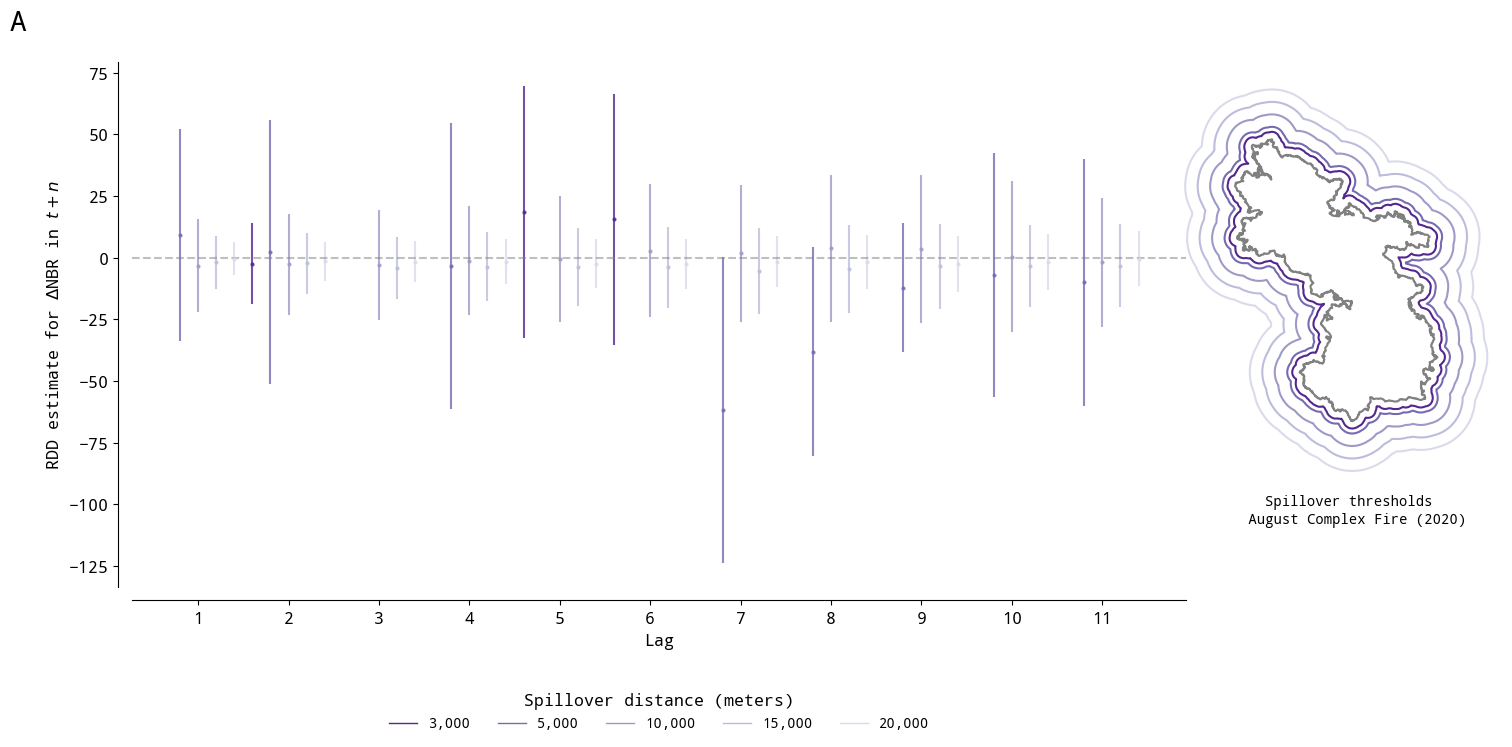

In [54]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plot coefficients in est_results and its confidence intervals
fig, ax = plt.subplots(figsize=(12, 8))

################################################################################
######################## PLOT RDD ESTIMATES PER LAGS  ##########################
################################################################################
data = (
    dist_results[
        (dist_results.index == "Robust")
        & (dist_results["ci_low"] < 1e2)
        & (dist_results["ci_high"] < 1e2)
    ]
    .groupby(["lag", "treat_buffer"], as_index=False)[["ci_high", "coef", "ci_low"]]
    .mean()
)

# Oranges for plotting
oranges = ["#dadaeb", "#bcbddc", "#9e9ac8", "#756bb1", "#54278f"]

buffers = np.sort(data["treat_buffer"].unique())
for buf, delta, color in zip(
    buffers, np.linspace(-0.4, 0.4, buffers.shape[0]), oranges[::-1]
):
    # Subset to buffer and calculate errors
    sub = data[data.treat_buffer == buf]
    sub.reset_index(drop=True, inplace=True)
    yerr_lower = np.abs(sub["coef"].values - sub["ci_low"].values)
    yerr_upper = np.abs(sub["coef"].values - sub["ci_high"].values)

    for i in range(len(sub)):
        ax.errorbar(
            x=sub.loc[i, "lag"] + delta,
            y=sub.loc[i, "coef"],
            yerr=[[yerr_lower[i]], [yerr_upper[i]]],
            color=color,
            linestyle="none",
            marker="o",
            alpha=0.8,
            markersize=2,
        )

template_plots(
    ax,
    xlab="Lag",
    ylab=r"RDD estimate for $\Delta$NBR in $t+n$",
    label="A",
    axis_text=12,
)


# Add a horizontal line at zero
ax.axhline(0, color="gray", linestyle="--", alpha=0.5)

# Add more ticks to the x-axis from 1 to 12
ax.set_xticks(range(1, 12))

################################################################################
######################### PLOT DISTANCE TO FIRE BOUNDARY #######################
################################################################################

ax_inset = inset_axes(
    ax,
    width="80%",
    height="80%",
    loc="upper right",
    bbox_to_anchor=(0.55, 0.0, 1, 1),
    bbox_transform=ax.transAxes,
)


# test_fire = test_dist_subset[test_dist_subset["all"] == "CA3966012280920200817"]

# Transform to geopandas
# test_fire = gpd.GeoDataFrame(
#     test_fire, geometry=gpd.points_from_xy(test_fire.lon, test_fire.lat)
# )

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Plot the geometry boundary and the exterior of the treatment buffer
mtbs_ca[mtbs_ca.Event_ID == "CA3966012280920200817"].geometry.boundary.plot(
    ax=ax_inset, color="gray"
)


for delta, color in zip(buffers, oranges[::-1]):
    mtbs_ca[mtbs_ca.Event_ID == "CA3966012280920200817"].geometry.buffer(
        delta
    ).exterior.plot(ax=ax_inset, color=color)

# test_fire[(test_fire["distance"] < -1000) | (test_fire["distance"] > 1000)].plot(
#     column="distance",
#     legend=True,
#     cmap="RdBu",
#     vmin=-10_000,
#     vmax=10_000,
#     ax=ax[1],
#     cax=cax,
#     legend_kwds={
#         "label": "Distance from fire boundary \n [meters]",
#         "orientation": "horizontal",
#         "extend": "both",
#     },
# )


# Create legend using the colors and the buffers
colors = [mcolors.to_rgba(c) for c in oranges[::-1]]
labels = [f"{format(int(b), ',d')}" for b in buffers]

# Create a legend with the colors and the buffers
ax.legend(
    [plt.Line2D([0], [0], lw=1, color=c) for c in colors],
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    fancybox=True,
    shadow=True,
    ncol=5,
    title=r"Spillover distance (meters)",
    fontsize=10,
    frameon=False,
)

template_plots(ax_inset, no_axis=True, ylab="", xlab="")

# Add text under the inset axis to explain the colors
ax_inset.text(
    0.55,
    -0.05,
    "Spillover thresholds \n August Complex Fire (2020)",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax_inset.transAxes,
    fontsize=10,
)

plt.tight_layout()
# plt.subplots_adjust(hspace=-0.01)

plt.savefig("../figs/rdd_estimates.png", dpi=300)